In [23]:
# initialization
import numpy as np
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, assemble, transpile
from qiskit_textbook.widgets import dj_widget
# import basic plot tools
from qiskit.visualization import plot_histogram
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
from qiskit_textbook.problems import dj_problem_oracle
from qiskit_textbook.tools import array_to_latex
MY_API_TOKEN=""

In [2]:
# DEUTSCH-JOZA ALGORITHM:
# BOOLEAN ORACLE for which f is unknown, all we know is f is either balance or constant.
# input is arbitrary length n-bit string.
# output is either 1 or 0.
# constant boolean function will always output T or F regardless of input.
# balanced boolean funciton will output as many 0s as 1s over the input.
# CLASSICAL SOLUTION: attempt to test for balanced with queries each consitsing of a different input. If the outputs are different, boom, we are done. It's balanced.
# Otherwise, we must continue testing..
# At least > than half of all possible inputs 2^(n-1) + 1 for 100% confidence or compute a probability that
# f is constant as function of k iputs as 1 - 1/(2^(k-1)). And truncate for a given confidence perfcent.
# QUANTUM SOLUTION: solve 100% confidecne with 1 call to f.
# <--> f is a quantum oracle that maps |x>|y> : |x>|y XOR f(x)>.
# maps the tensor product of x and y to the the tensor product of x with the XOR of y and f(x).
# CREATING QUANTUM ORACLE
dj_widget(size="small", case="balanced")
#https://www.cs.cmu.edu/~odonnell/quantum15/lecture05.pdf

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x00\xcc\x08\x06\x00\x00\x00;\xd7\x9c…

In [3]:
#These are not actually oracles, just functions:
# Boolean Function that is constant: for any input, the output is always the same.
# Bollean Function that is balanced: for any input, the output is always 0s for exactly half the input and 1s for the other half.
# since f(x) is always 1 or 0 regardless of input, set output to randomly selecte
# 0 or 1.
# set the length of the n-bit input string. 
n = 3
# CONSTANT ORACLE
const_oracle = QuantumCircuit(n+1)
output = np.random.randint(2) # random into from [0,2)
if output == 1: # say always 1
    const_oracle.x(n) # set output to |1> else leave as 0.
const_oracle.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘

{'1111': 2048}


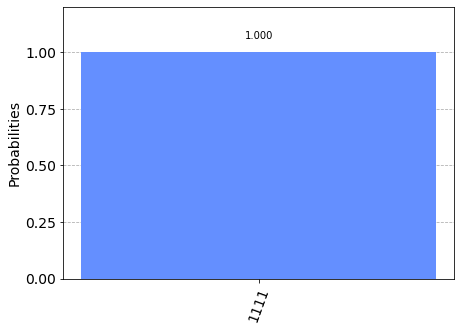

In [12]:
# BALANCED ORACLE
balanced_oracle = QuantumCircuit(n+1)

#which controls to wrap:
# Place X-gates
b_str = "101"
for qubit in range(len(b_str)): #0 to n-1
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)
balanced_oracle.draw()

# Use barrier as divider
balanced_oracle.barrier()

# Controlled-NOT gates
for qubit in range(n):
    balanced_oracle.cx(qubit, n)
    
# finish wrapping the controls in X-gates:
balanced_oracle.barrier()

# Place X-gates
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        balanced_oracle.x(qubit)

# Show oracle
balanced_oracle.draw()
# created a balanced oracle! :)


# THE FULL ALGORITHM
# initialize the input qubits in |+>
# and output qubit in |->
dj_circuit = QuantumCircuit(n+1, n)

# Apply H-gates
for qubit in range(n):
    dj_circuit.h(qubit) # H|0> = |+>

# Put output qubit in state |->
dj_circuit.x(n) # \1>
dj_circuit.h(n) # H|1> = |->
dj_circuit.draw()

# let's apply the oracle:
dj_circuit += balanced_oracle
dj_circuit.draw()

# do H on input register since H^-1 = H and measure
# Repeat H-gates
for qubit in range(n):
    dj_circuit.h(qubit)
dj_circuit.barrier()

# Measure
for i in range(n):
    dj_circuit.measure(i, i)

# Display circuit
dj_circuit.draw()
# Let's see the output:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
run_options = {'shots':2048} #1024 is the default shots.
qobj = assemble(dj_circuit, qasm_sim)
results = qasm_sim.run(qobj,**run_options).result()
answer = results.get_counts()
print(answer)
plot_histogram(answer)
# we can see 0% chanche to measure |000> and hence, 
# => f(x) is balanced.

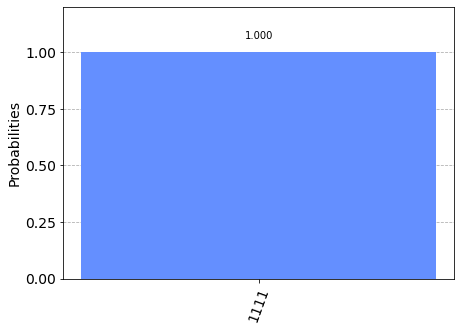

In [13]:
# GENERALIZED CIRCUITS
# generalised function that creates Deutsch-Joza oracles and turns them into quantum gates
# case = 'balanced' or 'constant', and n, the size of the input register:
def dj_oracle(case, n):
    # We need to make a QuantumCircuit object to return
    # This circuit has n+1 qubits: the size of the input,
    # plus one output qubit
    oracle_qc = QuantumCircuit(n+1)
    
    # First, let's deal with the case in which oracle is balanced
    if case == "balanced":
        # First generate a random number that tells us which CNOTs to
        # wrap in X-gates:
        b = np.random.randint(1,2**n)
        # Next, format 'b' as a binary string of length 'n', padded with zeros:
        b_str = format(b, '0'+str(n)+'b')
        # Next, we place the first X-gates. Each digit in our binary string 
        # corresponds to a qubit, if the digit is 0, we do nothing, if it's 1
        # we apply an X-gate to that qubit:
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)
        # Do the controlled-NOT gates for each qubit, using the output qubit 
        # as the target:
        for qubit in range(n):
            oracle_qc.cx(qubit, n)
        # Next, place the final X-gates
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                oracle_qc.x(qubit)

    # Case in which oracle is constant
    if case == "constant":
        # First decide what the fixed output of the oracle will be
        # (either always 0 or always 1)
        output = np.random.randint(2)
        if output == 1:
            oracle_qc.x(n)
    
    oracle_gate = oracle_qc.to_gate()
    oracle_gate.name = "Oracle" # To show when we display the circuit
    return oracle_gate

def dj_algorithm(oracle, n):
    dj_circuit = QuantumCircuit(n+1, n)
    # Set up the output qubit:
    dj_circuit.x(n)
    dj_circuit.h(n)
    # And set up the input register:
    for qubit in range(n):
        dj_circuit.h(qubit)
    # Let's append the oracle gate to our circuit:
    dj_circuit.append(oracle, range(n+1))
    # Finally, perform the H-gates again and measure:
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

n = 4
oracle_gate = dj_oracle('balanced', n)
dj_circuit = dj_algorithm(oracle_gate, n)
dj_circuit.draw()

# results
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)
# we can see 0% chanche to measure |000> and hence, 
# => f(x) is balanced.


ibmqfactory.load_account:WARNING:2021-05-24 09:52:54,153: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_manila


/Users/samiracarolinaolivamadrigal/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:13: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  del sys.path[0]


Job Status: job has successfully run


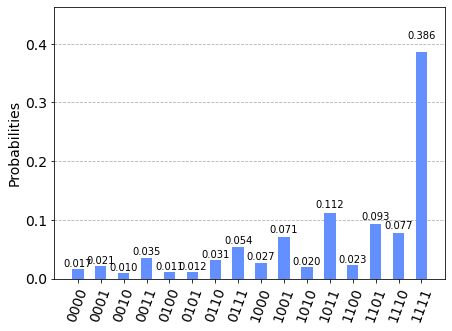

In [35]:
# Experiment with Real Devices 
# Load our saved IBMQ accounts and get the least busy backend device with greater than or equal to (n+1) qubits
API_TOKEN=""
#https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq
IBMQ.save_account(API_TOKEN,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= (n+1) and not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
shots = 1024
transpiled_dj_circuit = transpile(dj_circuit, backend, optimization_level=3)
qobj = assemble(transpiled_dj_circuit, backend)
job = backend.run(qobj)
job_monitor(job, interval=2)
# Get the results of the computation
results = job.result()
answer = results.get_counts()
plot_histogram(answer)
#the most likely result is 1111. The other results are due to errors in the quantum computation.

In [43]:
from qiskit_textbook.tools import array_to_latex
qc = QuantumCircuit(1)
#sv = [0,1]
sv = [0,-1]
qc.initialize(sv,0)
svsim = Aer.get_backend('statevector_simulator')
qobj = assemble(qc)
state = svsim.run(qobj).result().get_statevector()
array_to_latex(state, pretext="\\text{Statevector} = ")
print(state)

<IPython.core.display.Math object>

[ 0.+0.j -1.+0.j]


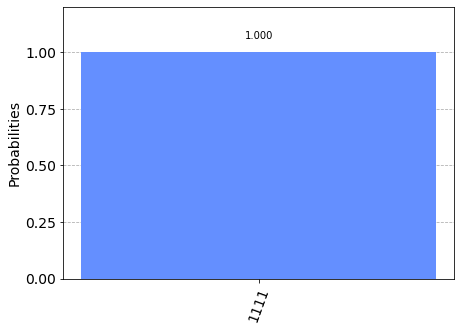

In [137]:
# https://www.sciencedirect.com/topics/engineering/boolean-function
# GENERALIZED CIRCUITS
# generalised function that creates Deutsch-Joza oracles and turns them into quantum gates
# case = 'balanced' or 'constant', and n, the size of the input register:
def generate_mapping(case, n): # map from |x>|y> -----> |x>|y XOR f(x)>
    """
    Unitary transformation/mapping from collective state |x>|y> -> |x>|y XOR f(x)>
    which correlates input to output.
    Since f(x) is hidden and all we know is that it returns either: all 0s/1s if constant
    or exactly n/2 0s and n/2 1s if balanced.
    
    :param case: balanced or constant
    :param n: size of input register 
    :return: a mapping |x>|y> -----> |x>|y XOR f(x)>
    """
    fx = QuantumCircuit(n+1)
    # BALANCED BOOLEAN FUNCTION
    if case == "balanced":
        #b_str = "1010" # "0000" # "1111"
        b = np.random.randint(1,2**n)  # generate random number in [1, 2^n)
        b_str = format(b, '0'+str(n)+'b')  # convert random number to binary string, my input string
        for qubit in range(len(b_str)):  # parse string bits
            if b_str[qubit] == '1':      # if set, apply x-gate to corresponding input qubit in fx circuit: |0> --> |1>
                fx.x(qubit)
        # all qubits in |1>, will apply x-gate to output :. generating a balanced boolean function
        # this one will output: 1010101... for any input.
        for qubit in range(n):
            fx.cx(qubit, n)
        # apply x-gate to all input qubits in |1>, completes wrap to return them back to |0>.
        for qubit in range(len(b_str)):
            if b_str[qubit] == '1':
                fx.x(qubit)

    # CONSTANT BOOLEAN FUNCTION
    # DECIDED OUR INTERPRESTATION 1ST (ALWAYS 0 OR ALWAYS 1)
    if case == "constant":
        # since output is fixed regardless of input, just set this at random.
        output = np.random.randint(2) # select 1 or 0 at random.
        if output == 1:
            fx.x(n)
    
    # covert to a gate.
    fx_gate = fx.to_gate()
    fx_gate.name = "U_f" 
    return fx_gate

def dj_algorithm(m, n):
    """
    DEUTSCH-JOSZA ALGORITHM - QUANTUM ORACLE THAT TELLS ME IF A HIDDEN BOOLEAN FUNCTION
    GURANTEED TO BE CONSTNAT OR BALANCED, IS EITHER IN JUST 1 QUERY.-- O(1) time.
    
    :param m: mapping, used to determine if boolean function is constant or balanced.
    :param n: size of input register
    :return: resulting circuit after measured.
    """
    dj_circuit = QuantumCircuit(n+1, n) # by default all qubits are initialized to |0>
    dj_circuit.x(n)  # |1>
    
    # Apply Hadamard to all qubits:
    dj_circuit.h(n)  # |->
    for qubit in range(n):
        dj_circuit.h(qubit)  # |+++.....+>
        
    # expand our circuit by connecting fx cirucit
    dj_circuit.append(m, range(n+1))

    # Apply Hadamard to only input register
    for qubit in range(n):
        dj_circuit.h(qubit)
    
    # Measure the circuit (input register)
    for i in range(n):
        dj_circuit.measure(i, i)
    
    return dj_circuit

n = 4
m_gate = generate_mapping('balanced', n)
dj_circuit = dj_algorithm(m_gate, n)
dj_circuit.draw()


# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
# results
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)
# we can see 0% chanche to measure |000> and hence, 
# => f(x) is balanced.

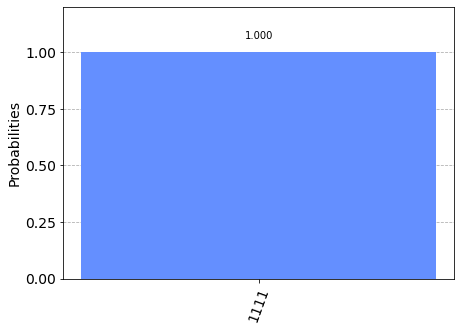

In [33]:
fx = dj_problem_oracle(1)
dj_circuit = dj_algorithm(fx, n)
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)  # BALANCED FUNCTION

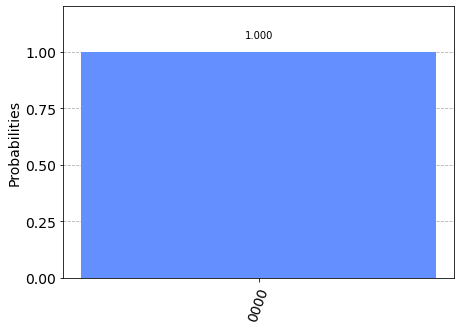

In [34]:
fx = dj_problem_oracle(2)
dj_circuit = dj_algorithm(fx, n)
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)  # CONSTANT FUNCTION

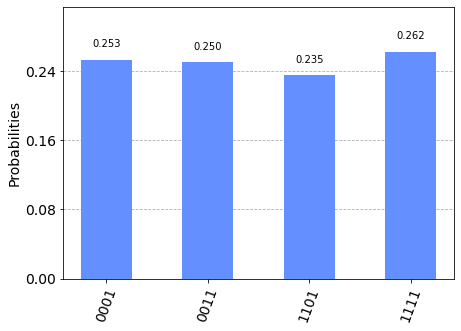

In [35]:
fx = dj_problem_oracle(3)
dj_circuit = dj_algorithm(fx, n)
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer) # => BALANCED

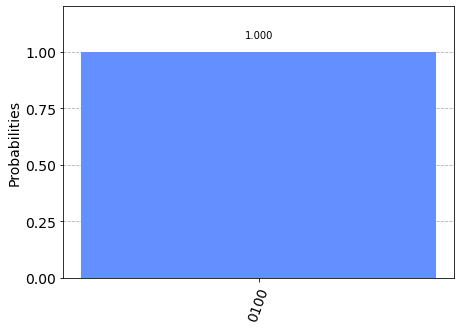

In [36]:
fx = dj_problem_oracle(4)
dj_circuit = dj_algorithm(fx, n)
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer) # BALANCED

There are only currently 4 oracles in this problem set, returning empty (balanced) gate


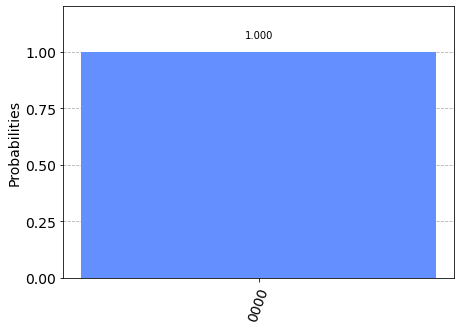

In [37]:
fx = dj_problem_oracle(5)
dj_circuit = dj_algorithm(fx, n)
transpiled_dj_circuit = transpile(dj_circuit, qasm_sim)
qobj = assemble(transpiled_dj_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer) # CONSTANT BOOLEAN FUNCTION

In [133]:
n=3
fx = QuantumCircuit(n+1)
#rand_num = np.random.randint(1,2**n)  # generate random number in [1, 2^n)
#b_str = format(rand_num, '0'+str(n)+'b')  # convert random number to binary string, my input string
b_str = "1010" #"000"#"111"#"000"
for qubit in range(len(b_str)):  # parse string bits
    if b_str[qubit] == '1':      # if set, apply x-gate to corresponding input qubit in fx circuit: |0> --> |1>
        fx.x(qubit)
for qubit in range(n):
    fx.cx(qubit, n)
for qubit in range(len(b_str)):
    if b_str[qubit] == '1':
        fx.x(qubit)
fx.draw()

┌───┐     ┌───┐          
q_0: ┤ X ├──■──┤ X ├──────────
     └───┘  │  └───┘          
q_1: ───────┼────■────────────
     ┌───┐  │    │       ┌───┐
q_2: ┤ X ├──┼────┼────■──┤ X ├
     └───┘┌─┴─┐┌─┴─┐┌─┴─┐└───┘
q_3: ─────┤ X ├┤ X ├┤ X ├─────
          └───┘└───┘└───┘

In [129]:
n=2
svsim = Aer.get_backend('statevector_simulator')
qc = QuantumCircuit(n+1)
for i in range(0,n):
    qc.h(i)
qc.x(n)
qc.h(n) #q1=|->
for i in range(0,n):
    qc.cx(i,n)
    qobj = assemble(qc)
    final_state = svsim.run(qobj).result().get_statevector()
    print(final_state)
    array_to_latex(final_state, pretext="\\text{Statevector = }")

[ 0.35355339-4.32978028e-17j -0.35355339+4.32978028e-17j
  0.35355339-4.32978028e-17j -0.35355339+4.32978028e-17j
 -0.35355339+4.32978028e-17j  0.35355339-4.32978028e-17j
 -0.35355339+4.32978028e-17j  0.35355339-4.32978028e-17j]


<IPython.core.display.Math object>

[ 0.35355339-4.32978028e-17j -0.35355339+4.32978028e-17j
 -0.35355339+4.32978028e-17j  0.35355339-4.32978028e-17j
 -0.35355339+4.32978028e-17j  0.35355339-4.32978028e-17j
  0.35355339-4.32978028e-17j -0.35355339+4.32978028e-17j]


<IPython.core.display.Math object>

HTMLMath(value='$$ |00\\rangle = |00\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x00\xcc\x08\x06\x00\x00\x00;\xd7\x9c…

ibmqfactory.load_account:WARNING:2021-06-14 15:40:49,819: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_belem


/Users/samiracarolinaolivamadrigal/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:79: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.


Job Status: job has successfully run


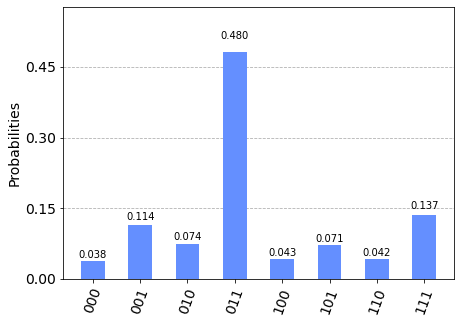

In [142]:
from qiskit_textbook.widgets import bv_widget
bv_widget(2, "11")

# initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, transpile, assemble

# import basic plot tools
from qiskit.visualization import plot_histogram
n = 3 # number of qubits used to represent s
s = '011'   # the hidden binary string

# We need a circuit with n qubits, plus one auxiliary qubit
# Also need n classical bits to write the output to
bv_circuit = QuantumCircuit(n+1, n)

# put auxiliary in state |->
bv_circuit.h(n)
bv_circuit.z(n)

# Apply Hadamard gates before querying the oracle
for i in range(n):
    bv_circuit.h(i)
    
# Apply barrier 
bv_circuit.barrier()

# Apply the inner-product oracle
s = s[::-1] # reverse s to fit qiskit's qubit ordering
for q in range(n):
    if s[q] == '0':
        bv_circuit.i(q)
    else:
        bv_circuit.cx(q, n)
        
# Apply barrier 
bv_circuit.barrier()

#Apply Hadamard gates after querying the oracle
for i in range(n):
    bv_circuit.h(i)

# Measurement
for i in range(n):
    bv_circuit.measure(i, i)

bv_circuit.draw()
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 1024
qobj = assemble(bv_circuit)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)

# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
API_TOKEN=""
#https://quantum-computing.ibm.com/lab/docs/iql/manage/account/ibmq
IBMQ.save_account(API_TOKEN,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
provider.backends()
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits <= 5 and
                                   x.configuration().n_qubits >= 2 and
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor

shots = 1024
transpiled_bv_circuit = transpile(bv_circuit, backend)
qobj = assemble(transpiled_bv_circuit, shots=shots)
job = backend.run(qobj)

job_monitor(job, interval=2)
# Get the results from the computation
results = job.result()
answer = results.get_counts()

plot_histogram(answer)
#As we can see, most of the results are 011. The other results are due to errors in the quantum computation.

In [9]:
#Bernstein-Vazirani algorithm in action on different oracles:
from qiskit_textbook.widgets import bv_widget
bv_widget(3, "011", hide_oracle=False)
# Modify the implementation for a secret string  s = 1011 
bv_widget(4, "1011", hide_oracle=False)
# Modify the implementation for a secret string  s = "11101101"
bv_widget(4, "11101101", hide_oracle=False) # too long for this simulation widget; but correct for last 4 bits.
# yes, results are as expected: H, Orable, H, measure. Observe output is in reverse order.

HTMLMath(value='$$ |000\\rangle = |000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x01\x08\x08\x06\x00\x00\x00\x17\xd9\…

HTMLMath(value='$$ |0000\\rangle = |0000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x01E\x08\x06\x00\x00\x00\xa4\x1f\xd2…

Error: s is too long, trimming the first 4 bits and using '1101' instead.


HTMLMath(value='$$ |0000\\rangle = |0000\\rangle $$')

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x00\xce\x00\x00\x01E\x08\x06\x00\x00\x00\xa4\x1f\xd2…

In [14]:
# importing Qiskit
from qiskit import IBMQ, Aer
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, transpile, assemble
# import basic plot tools
from qiskit.visualization import plot_histogram
from qiskit_textbook.tools import simon_oracle
# we actually do not care about the output of the second register, and will only measure the first register.


b = '110' #secret string
n = len(b)
simon_circuit = QuantumCircuit(n*2, n)

# Apply Hadamard gates to 1st reg before querying the oracle
simon_circuit.h(range(n))    
    
# Apply barrier for visual separation
simon_circuit.barrier()

# Apply ORACLE
simon_circuit += simon_oracle(b)

# Apply barrier for visual separation
simon_circuit.barrier()

# Apply Hadamard gates to 1st input register
simon_circuit.h(range(n))

# Measure qubits
simon_circuit.measure(range(n), range(n))
simon_circuit.draw()  

┌───┐ ░                           ░ ┌───┐┌─┐      
q_0: ┤ H ├─░───■───────────────────────░─┤ H ├┤M├──────
     ├───┤ ░   │                       ░ ├───┤└╥┘┌─┐   
q_1: ┤ H ├─░───┼────■─────────■────■───░─┤ H ├─╫─┤M├───
     ├───┤ ░   │    │         │    │   ░ ├───┤ ║ └╥┘┌─┐
q_2: ┤ H ├─░───┼────┼────■────┼────┼───░─┤ H ├─╫──╫─┤M├
     └───┘ ░ ┌─┴─┐  │    │    │    │   ░ └───┘ ║  ║ └╥┘
q_3: ──────░─┤ X ├──┼────┼────┼────┼───░───────╫──╫──╫─
           ░ └───┘┌─┴─┐  │  ┌─┴─┐  │   ░       ║  ║  ║ 
q_4: ──────░──────┤ X ├──┼──┤ X ├──┼───░───────╫──╫──╫─
           ░      └───┘┌─┴─┐└───┘┌─┴─┐ ░       ║  ║  ║ 
q_5: ──────░───────────┤ X ├─────┤ X ├─░───────╫──╫──╫─
           ░           └───┘     └───┘ ░       ║  ║  ║ 
c: 3/══════════════════════════════════════════╩══╩══╩═
                                               0  1  2

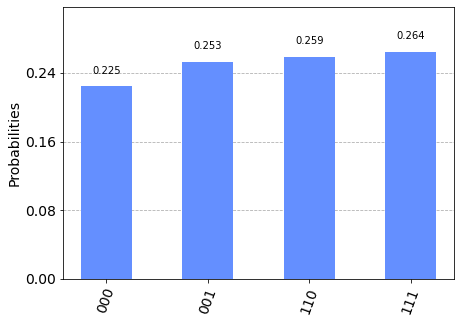

In [21]:
# use local simulator
qasm_sim = Aer.get_backend('qasm_simulator')
qobj = assemble(simon_circuit, shots=1024)
results = qasm_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [22]:
# Calculate the dot product of the results
def bdotz(b, z):
    accum = 0
    for i in range(len(b)):
        accum += int(b[i]) * int(z[i])
    return (accum % 2)

for z in counts:
    print( '{}.{} = {} (mod 2)'.format(b, z, bdotz(b,z)) )
    
# we can recover the value of  b= 110 by solving this set of simultaneous equations.

110.111 = 0 (mod 2)
110.001 = 0 (mod 2)
110.110 = 0 (mod 2)
110.000 = 0 (mod 2)


In [24]:
#3b. Experiment with Real Devices 
b = '11'
n = len(b)
simon_circuit_2 = QuantumCircuit(n*2, n)

# Apply Hadamard gates before querying the oracle
simon_circuit_2.h(range(n))

# Query oracle
simon_circuit_2 += simon_oracle(b)

# Apply Hadamard gates to the input register
simon_circuit_2.h(range(n))

# Measure qubits
simon_circuit_2.measure(range(n), range(n))
simon_circuit_2.draw()


┌───┐                         ┌───┐┌─┐
q_0: ┤ H ├──■─────────■─────────■──┤ H ├┤M├
     ├───┤  │         │  ┌───┐  │  └┬─┬┘└╥┘
q_1: ┤ H ├──┼────■────┼──┤ H ├──┼───┤M├──╫─
     └───┘┌─┴─┐  │  ┌─┴─┐└───┘  │   └╥┘  ║ 
q_2: ─────┤ X ├──┼──┤ X ├───────┼────╫───╫─
          └───┘┌─┴─┐└───┘     ┌─┴─┐  ║   ║ 
q_3: ──────────┤ X ├──────────┤ X ├──╫───╫─
               └───┘          └───┘  ║   ║ 
c: 2/════════════════════════════════╩═══╩═
                                     1   0

least busy backend:  ibmq_belem


/Users/samiracarolinaolivamadrigal/Library/Python/3.7/lib/python/site-packages/ipykernel_launcher.py:16: DeprecationWarning: Passing a Qobj to Backend.run is deprecated and will be removed in a future release. Please pass in circuits or pulse schedules instead.
  app.launch_new_instance()


Job Status: job has successfully run


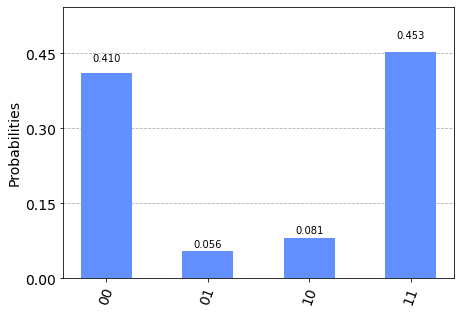

In [25]:
# DIFF CIRCUIT FROM SECTION 2, DIFF OUTPUT TOO.
# BUT 2:1 SAME COLLISION f(a) = f(a ^ b)
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to 5 qubits
IBMQ.save_account(MY_API_TOKEN,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= n and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

# Execute and monitor the job
from qiskit.tools.monitor import job_monitor
shots = 1024
transpiled_simon_circuit = transpile(simon_circuit_2, backend, optimization_level=3)
qobj = assemble(transpiled_simon_circuit, shots=shots)
job = backend.run(qobj)
job_monitor(job, interval=2)
# Get results and plot counts
device_counts = job.result().get_counts()
plot_histogram(device_counts)

In [ ]:
# TDB... time

In [32]:
# QUANTUM FOURIER TRANSFORM
# H, and CROT_k defined in n OpenQASM 
import numpy as np
from numpy import pi
# importing Qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer, IBMQ
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram, plot_bloch_multivector
# START OUT 3-QUBIT
qc = QuantumCircuit(3)
# RECALL little endian
qc.h(2)
qc.draw()
# turn this an extra quarter turn if qubit 1 is in the state |1>
qc.cp(pi/2, 1, 2) # CROT from q1=control and q2=target
qc.draw()
qc.cp(pi/4, 0, 2) # And another eighth turn if q0 in |1>
qc.draw()
# repeat the process: starting from q1
qc.h(1)
qc.cp(pi/2, 0, 1)
# apply h to last or "lsq"
qc.h(0)
qc.draw()
# SINCE ONLY 3: SWAP Q0 AND Q2
qc.swap(0,2)
qc.draw()


┌───┐   
q_0: ───────────────■─────────────■───────┤ H ├─X─
                    │       ┌───┐ │P(π/2) └───┘ │ 
q_1: ──────■────────┼───────┤ H ├─■─────────────┼─
     ┌───┐ │P(π/2)  │P(π/4) └───┘               │ 
q_2: ┤ H ├─■────────■───────────────────────────X─
     └───┘

In [36]:
# General QFT Function
# It is easier to build a circuit that implements the QFT with the qubits upside down, then swap them afterwards;
# we will start off by creating the function that rotates our qubits correctly. 
def qft_rotations(circuit, n):
    """Performs qft on the first n qubits in circuit (without swaps)"""
    if n == 0:
        return circuit
    n -= 1
    circuit.h(n)
    for qubit in range(n):
        circuit.cp(pi/2**(n-qubit), qubit, n)
    # At the end of our function, we call the same function again on
    # the next qubits (we reduced n by one earlier in the function)
    qft_rotations(circuit, n)
# Let's see how it looks:
qc = QuantumCircuit(3)
qft_rotations(qc,3)
qc.draw()

┌───┐
q_0: ──────■──────────────────────■───────┤ H ├
           │                ┌───┐ │P(π/2) └───┘
q_1: ──────┼────────■───────┤ H ├─■────────────
     ┌───┐ │P(π/4)  │P(π/2) └───┘              
q_2: ┤ H ├─■────────■──────────────────────────
     └───┘

In [37]:
# Let's see how it looks:
qc = QuantumCircuit(4)
qft_rotations(qc,4)
qc.draw()


┌───┐
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├
           │                               │                ┌───┐ │P(π/2) └───┘
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■────────────
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘              
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■──────────────────────────
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────
     └───┘

In [39]:
from qiskit_textbook.widgets import scalable_circuit
scalable_circuit(qft_rotations)

IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04\x19\x00\x00\x01\x08\x08\x06\x00\x00\x00\x1a\xcd,…

In [41]:
# Finally, we need to add the swaps at the end of the QFT function to match the definition of the QFT. 
# We will combine this into the final function qft():

def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

def qft(circuit, n):
    """QFT on the first n qubits in circuit"""
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

# Let's see how it looks:
qc = QuantumCircuit(4)
qft(qc,4)
qc.draw()

┌───┐»
q_0: ──────■───────────────────────────────■──────────────────────■───────┤ H ├»
           │                               │                ┌───┐ │P(π/2) └───┘»
q_1: ──────┼────────■──────────────────────┼────────■───────┤ H ├─■─────────X──»
           │        │                ┌───┐ │P(π/4)  │P(π/2) └───┘           │  »
q_2: ──────┼────────┼────────■───────┤ H ├─■────────■───────────────────────X──»
     ┌───┐ │P(π/8)  │P(π/4)  │P(π/2) └───┘                                     »
q_3: ┤ H ├─■────────■────────■─────────────────────────────────────────────────»
     └───┘                                                                     »
«        
«q_0: ─X─
«      │ 
«q_1: ─┼─
«      │ 
«q_2: ─┼─
«      │ 
«q_3: ─X─
«

In [42]:
#This is the generalised circuit for the quantum Fourier transform.
#We can again see how this scales using the widget below:
scalable_circuit(qft)


IntSlider(value=4, max=8, min=1)

Image(value=b'\x89PNG\r\n\x1a\n\x00\x00\x00\rIHDR\x00\x00\x04U\x00\x00\x01\x08\x08\x06\x00\x00\x00\x9eK\xcbE\x…

In [43]:
# demonstrate this circuit works correctly. To do this we must first encode a number in the computational basis. 
# We can see the number 5 in binary is 101:
bin(5)

'0b101'

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


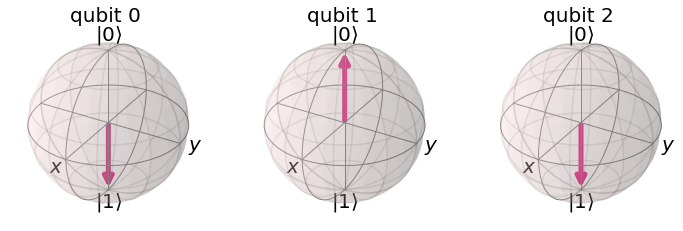

In [48]:
# (The 0b just reminds us this is a binary number). Let's encode this into our qubits:
# Create the circuit
qc = QuantumCircuit(3)

# LETS ENCODE IN OUR COMPUTATIONAL BASIS Z
# Encode the state 5
qc.x(0)
qc.x(2)
qc.draw()

# check states:
sim = Aer.get_backend("aer_simulator")
qc_init = qc.copy()
qc_init.save_statevector()
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [49]:
# Finally, let's use our QFT function and view the final state of our qubits:
qft(qc,3)
qc.draw()

┌───┐                                     ┌───┐   
q_0: ┤ X ├──────■──────────────────────■───────┤ H ├─X─
     └───┘      │                ┌───┐ │P(π/2) └───┘ │ 
q_1: ───────────┼────────■───────┤ H ├─■─────────────┼─
     ┌───┐┌───┐ │P(π/4)  │P(π/2) └───┘               │ 
q_2: ┤ X ├┤ H ├─■────────■───────────────────────────X─
     └───┘└───┘

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


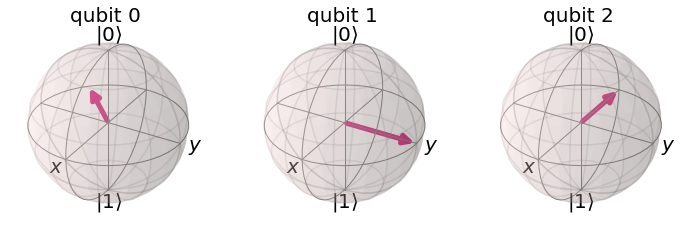

In [50]:
qc.save_statevector()
statevector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(statevector)

In [55]:
#QFT function has worked correctly. |0>~ =  |+++>
#8.3 Running QFT on a Real Quantum Device 
# demonstrate and investigate the QFT working on real hardware, we can instead create the state |5>~
#  run the QFT in reverse, and verify the output is the state is |5>
# since running above => results would be completely random, since all qubits are in equal superposition of the z-basis
def inverse_qft(circuit, n):
    """Does the inverse QFT on the first n qubits in circuit"""
    # First we create a QFT circuit of the correct size:
    qft_circ = qft(QuantumCircuit(n), n)
    # Then we take the inverse of this circuit
    invqft_circ = qft_circ.inverse()
    # And add it to the first n qubits in our existing circuit
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() allows us to see the individual gates

# put our qubits in the state in |5>~
nqubits = 3
number = 5
qc = QuantumCircuit(nqubits)
for qubit in range(nqubits):
    qc.h(qubit)
qc.p(number*pi/4,0)
qc.p(number*pi/2,1)
qc.p(number*pi,2)
qc.draw()

┌───┐┌─────────┐
q_0: ┤ H ├┤ P(5π/4) ├
     ├───┤├─────────┤
q_1: ┤ H ├┤ P(5π/2) ├
     ├───┤└┬───────┬┘
q_2: ┤ H ├─┤ P(5π) ├─
     └───┘ └───────┘

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


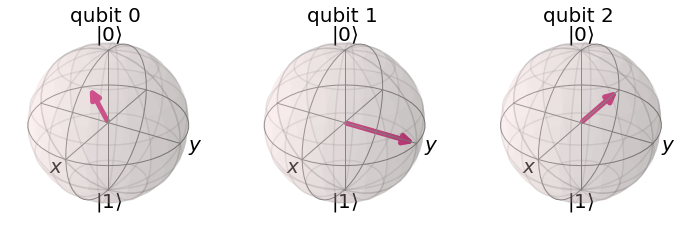

In [56]:
# verify state is |5>~
qc_init = qc.copy()
qc_init.save_statevector()
sim = Aer.get_backend("aer_simulator")
statevector = sim.run(qc_init).result().get_statevector()
plot_bloch_multivector(statevector)

In [57]:
# apply invers QFT
qc = inverse_qft(qc, nqubits)
qc.measure_all()
qc.draw()

┌─────────┐┌─────────────┐   ┌───┐                                   »
   q_0: ┤ U2(0,π) ├┤ U(0,0,5π/4) ├─X─┤ H ├─■────────────────────────■────────»
        ├─────────┤├─────────────┤ │ └───┘ │P(-π/2) ┌───┐           │        »
   q_1: ┤ U2(0,π) ├┤ U(0,0,5π/2) ├─┼───────■────────┤ H ├─■─────────┼────────»
        ├─────────┤└┬───────────┬┘ │                └───┘ │P(-π/2)  │P(-π/4) »
   q_2: ┤ U2(0,π) ├─┤ U(0,0,5π) ├──X──────────────────────■─────────■────────»
        └─────────┘ └───────────┘                                            »
meas: 3/═════════════════════════════════════════════════════════════════════»
                                                                             »
«              ░ ┌─┐      
«   q_0: ──────░─┤M├──────
«              ░ └╥┘┌─┐   
«   q_1: ──────░──╫─┤M├───
«        ┌───┐ ░  ║ └╥┘┌─┐
«   q_2: ┤ H ├─░──╫──╫─┤M├
«        └───┘ ░  ║  ║ └╥┘
«meas: 3/═════════╩══╩══╩═
«                 0  1  2

In [58]:
# Load our saved IBMQ accounts and get the least busy backend device with less than or equal to nqubits
IBMQ.save_account(MY_API_TOKEN,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= nqubits 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)

ibmqfactory.load_account:WARNING:2021-06-23 18:04:53,644: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_quito


Job Status: job has successfully run


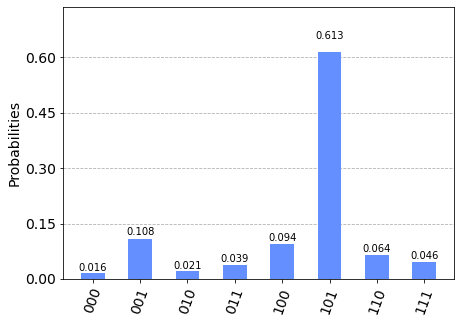

In [59]:
shots = 2048
transpiled_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(transpiled_qc, shots=shots)
job_monitor(job)
counts = job.result().get_counts()
plot_histogram(counts)
# verify actual state is |5> in computational basis

In [75]:
# We (hopefully) see that the highest probability outcome is  101
# TDB PS

In [76]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [77]:
# |psi> = |1>
qpe = QuantumCircuit(4, 3)
qpe.x(3)
qpe.draw()

q_0: ─────
          
q_1: ─────
          
q_2: ─────
     ┌───┐
q_3: ┤ X ├
     └───┘
c: 3/═════

In [78]:
# apply H to counter reg
for qubit in range(3):
    qpe.h(qubit)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ X ├
     └───┘
c: 3/═════

In [79]:
# controlled unitary operations
# recall qiskit is little endian
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe.cp(math.pi/4, counting_qubit, 3); # This is C-U
    repetitions *= 2
qpe.draw()

┌───┐                                                               
q_0: ┤ H ├─■─────────────────────────────────────────────────────────────
     ├───┤ │                                                             
q_1: ┤ H ├─┼────────■────────■───────────────────────────────────────────
     ├───┤ │        │        │                                           
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■───────
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4) 
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■───────
     └───┘                                                               
c: 3/════════════════════════════════════════════════════════════════════

In [80]:
# inverse quantum Fourier transformation
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)
        
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, 3)
# Measure
qpe.barrier()
for n in range(3):
    qpe.measure(n,n)

qpe.draw()


┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                         ░ ┌─┐      
«q_0: ┤ H ├─■──────────────■────────────────────────░─┤M├──────
«     └───┘ │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ─────────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                             └───┘ ░  ║  ║ └╥┘
«q_3: ──────────────────────────────────────────────░──╫──╫──╫─
«                                                   ░  ║  ║  ║ 
«c: 3/═════════════════════════════════════════════════╩══╩══╩═
«                                                      0  1  2

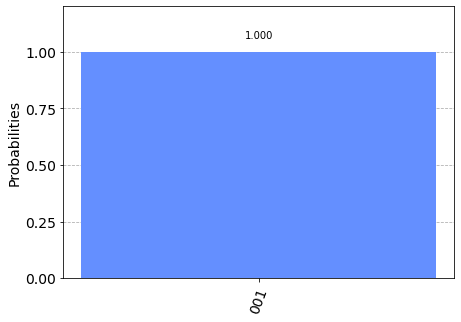

In [82]:
aer_sim = Aer.get_backend('aer_simulator')
shots = 2048
t_qpe = transpile(qpe, aer_sim)
qobj = assemble(t_qpe, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()
plot_histogram(answer)

In [83]:
# when we measure, we get 001 with 100% probability
# 2^nTheta = 001 =>001/2^n = theta = 1/8

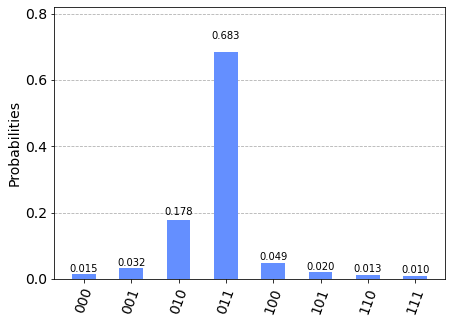

In [85]:
# EXAMPLE FOR GATE WITH THETA = 1/3
# Create and set up circuit
qpe2 = QuantumCircuit(4, 3)

# Apply H-Gates to counting qubits:
for qubit in range(3):
    qpe2.h(qubit)

# Prepare our eigenstate |psi>:
qpe2.x(3)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(3):
    for i in range(repetitions):
        qpe2.cp(angle, counting_qubit, 3);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe2, 3)

# Measure of course!
for n in range(3):
    qpe2.measure(n,n)

qpe2.draw()
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe2 = transpile(qpe2, aer_sim)
qobj = assemble(t_qpe2, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)


In [88]:
# for 011, get angle=0.25, exp= 0.33, off by
# The true value of  θ lies between the values we can get from our counting bits, 
# and this gives us uncertainty and imprecision.
# To get more precision we simply add more counting qubits. We are going to add two more counting qubits:
# Create and set up circuit
qpe3 = QuantumCircuit(6, 5)

# Apply H-Gates to counting qubits:
for qubit in range(5):
    qpe3.h(qubit)

# Prepare our eigenstate |psi>:
qpe3.x(5)

# Do the controlled-U operations:
angle = 2*math.pi/3
repetitions = 1
for counting_qubit in range(5):
    for i in range(repetitions):
        qpe3.cp(angle, counting_qubit, 5);
    repetitions *= 2

# Do the inverse QFT:
qft_dagger(qpe3, 5)

# Measure of course!
qpe3.barrier()
for n in range(5):
    qpe3.measure(n,n)
qpe3.draw()

┌───┐                                                            »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────»
     ├───┤ │                                                          »
q_1: ┤ H ├─┼─────────■─────────■──────────────────────────────────────»
     ├───┤ │         │         │                                      »
q_2: ┤ H ├─┼─────────┼─────────┼─────────■─────────■─────────■────────»
     ├───┤ │         │         │         │         │         │        »
q_3: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │         │         │         │         │         │        »
q_4: ┤ H ├─┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
     ├───┤ │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
q_5: ┤ X ├─■─────────■─────────■─────────■─────────■─────────■────────»
     └───┘                                                            »
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ─■────────────────────────────────────────────────────────────────────»
«      │                                                                    »
«q_3: ─┼─────────■─────────■─────────■─────────■─────────■─────────■────────»
«      │         │         │         │         │         │         │        »
«q_4: ─┼─────────┼─────────┼─────────┼─────────┼─────────┼─────────┼────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ────────────────────────X─────────────────────────────────────────────»
«                             │                                             »
«q_2: ────────────────────────┼─────────────────────────────────────────────»
«                             │                                             »
«q_3: ─■─────────■────────────X─────────────────────────────────────────────»
«      │         │                                                          »
«q_4: ─┼─────────┼─────────■─────────■─────────■─────────■─────────■────────»
«      │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3)  │P(2π/3) »
«q_5: ─■─────────■─────────■─────────■─────────■─────────■─────────■────────»
«                                                                           »
«c: 5/══════════════════════════════════════════════════════════════════════»
«                                                                           »
«                                                                           »
«q_0: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_1: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_2: ──────────────────────────────────────────────────────────────────────»
«                                                                           »
«q_3: ─────────────────────────────────

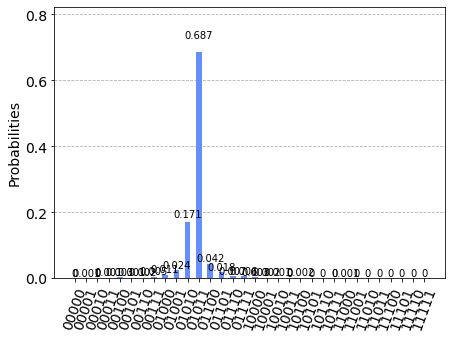

In [89]:
# Let's see the results!
aer_sim = Aer.get_backend('aer_simulator')
shots = 4096
t_qpe3 = transpile(qpe3, aer_sim)
qobj = assemble(t_qpe3, shots=shots)
results = aer_sim.run(qobj).result()
answer = results.get_counts()

plot_histogram(answer)
# The two most likely measurements are now 01011 (decimal 11) and 01010 (decimal 10). Measuring these results would tell us  
# θ is: 0.334 or 0.313

In [90]:
# Experiment with Real Devices 
qpe.draw()


┌───┐                                                                ░    »
q_0: ┤ H ├─■──────────────────────────────────────────────────────────────░──X─»
     ├───┤ │                                                              ░  │ »
q_1: ┤ H ├─┼────────■────────■────────────────────────────────────────────░──┼─»
     ├───┤ │        │        │                                            ░  │ »
q_2: ┤ H ├─┼────────┼────────┼────────■────────■────────■────────■────────░──X─»
     ├───┤ │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  │P(π/4)  ░    »
q_3: ┤ X ├─■────────■────────■────────■────────■────────■────────■────────░────»
     └───┘                                                                ░    »
c: 3/══════════════════════════════════════════════════════════════════════════»
                                                                               »
«     ┌───┐                                         ░ ┌─┐      
«q_0: ┤ H ├─■──────────────■────────────────────────░─┤M├──────
«     └───┘ │P(-π/2) ┌───┐ │                        ░ └╥┘┌─┐   
«q_1: ──────■────────┤ H ├─┼─────────■──────────────░──╫─┤M├───
«                    └───┘ │P(-π/4)  │P(-π/2) ┌───┐ ░  ║ └╥┘┌─┐
«q_2: ─────────────────────■─────────■────────┤ H ├─░──╫──╫─┤M├
«                                             └───┘ ░  ║  ║ └╥┘
«q_3: ──────────────────────────────────────────────░──╫──╫──╫─
«                                                   ░  ║  ║  ║ 
«c: 3/═════════════════════════════════════════════════╩══╩══╩═
«                                                      0  1  2

ibmqfactory.load_account:WARNING:2021-06-24 16:41:58,791: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


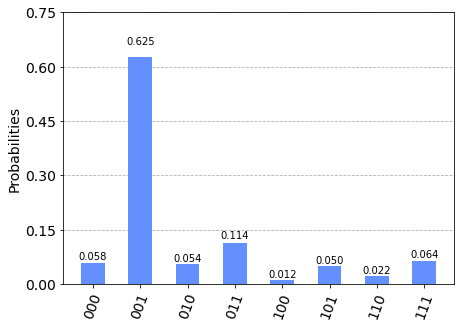

In [92]:
IBMQ.save_account(MY_API_TOKEN,overwrite=True)
IBMQ.load_account()
from qiskit.tools.monitor import job_monitor
provider = IBMQ.get_provider(hub='ibm-q')
santiago = provider.get_backend('ibmq_santiago')

# Run with 2048 shots
shots = 2048
t_qpe = transpile(qpe, santiago, optimization_level=3)
job = santiago.run(t_qpe, shots=shots)
job_monitor(job)

# get the results from the computation
results = job.result()
answer = results.get_counts(qpe)

plot_histogram(answer)

In [93]:
# Unlike the simulator, there is a probability of measuring something other than 001, 
# this is due to noise and gate errors in the quantum computer.
# The quantum phase estimation algorithm may seem pointless, since we have to know  θ to perform the
# controlled- U operations on our quantum computer.
# POINT: IT'S POSSIBLE TO CREATE CIRCUITS FOR WHICH WE DON'T KNOW THETA... AND FINDING IT CAN TELL US HOW
# TO FACTOR A NUMBER.... :)
# TBD
import matplotlib.pyplot as plt
import numpy as np
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram
from math import gcd
from numpy.random import randint
import pandas as pd
from fractions import Fraction
print("Imports Successful")

Imports Successful


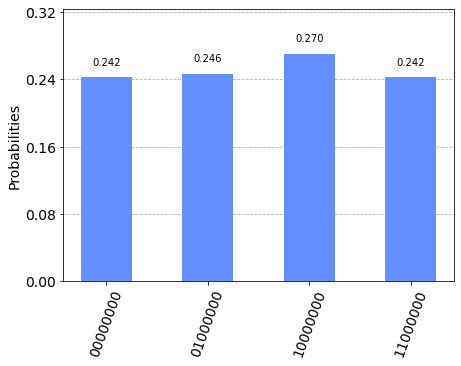

In [97]:
# The Problem: Period Finding
# SHOR
def c_amod15(a, power):
    """Controlled multiplication by a mod 15"""
    if a not in [2,7,8,11,13]:
        raise ValueError("'a' must be 2,7,8,11 or 13")
    U = QuantumCircuit(4)        
    for iteration in range(power):
        if a in [2,13]:
            U.swap(0,1)
            U.swap(1,2)
            U.swap(2,3)
        if a in [7,8]:
            U.swap(2,3)
            U.swap(1,2)
            U.swap(0,1)
        if a == 11:
            U.swap(1,3)
            U.swap(0,2)
        if a in [7,11,13]:
            for q in range(4):
                U.x(q)
    U = U.to_gate()
    U.name = "%i^%i mod 15" % (a, power)
    c_U = U.control()
    return c_U

# Specify variables
n_count = 8  # number of counting qubits
a = 7

def qft_dagger(n):
    """n-qubit QFTdagger the first n qubits in circ"""
    qc = QuantumCircuit(n)
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-np.pi/float(2**(j-m)), m, j)
        qc.h(j)
    qc.name = "QFT†"
    return qc

#With these building blocks we can easily construct the circuit for Shor's algorithm:
# Create QuantumCircuit with n_count counting qubits
# plus 4 qubits for U to act on
qc = QuantumCircuit(n_count + 4, n_count)

# Initialize counting qubits
# in state |+>
for q in range(n_count):
    qc.h(q)
    
# And auxiliary register in state |1>
qc.x(3+n_count)

# Do controlled-U operations
for q in range(n_count):
    qc.append(c_amod15(a, 2**q), 
             [q] + [i+n_count for i in range(4)])

# Do inverse-QFT
qc.append(qft_dagger(n_count), range(n_count))

# Measure circuit
qc.measure(range(n_count), range(n_count))
qc.draw(fold=-1)  # -1 means 'do not fold' 
aer_sim = Aer.get_backend('aer_simulator')
t_qc = transpile(qc, aer_sim)
qobj = assemble(t_qc)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [98]:
# ESTIMATING THE PHASES.
# Since we have 3 qubits, these results correspond to measured phases of:
rows, measured_phases = [], []
for output in counts:
    decimal = int(output, 2)  # Convert (base 2) string to decimal
    phase = decimal/(2**n_count)  # Find corresponding eigenvalue
    measured_phases.append(phase)
    # Add these values to the rows in our table:
    rows.append([f"{output}(bin) = {decimal:>3}(dec)", 
                 f"{decimal}/{2**n_count} = {phase:.2f}"])
# Print the rows in a table
headers=["Register Output", "Phase"]
df = pd.DataFrame(rows, columns=headers)
print(df)


            Register Output           Phase
0  00000000(bin) =   0(dec)    0/256 = 0.00
1  01000000(bin) =  64(dec)   64/256 = 0.25
2  11000000(bin) = 192(dec)  192/256 = 0.75
3  10000000(bin) = 128(dec)  128/256 = 0.50


In [99]:
# We can now use the continued fractions algorithm to attempt to find  
# s and r
# PYTHON FRACTION gives fractions that return the result exactly 
#  .limit_denominator() method to get the fraction that most closely resembles our float,
# Get fraction that most closely resembles 0.666
# with denominator < 15
Fraction(0.666).limit_denominator(15)

Fraction(2, 3)

In [102]:
Fraction(0.666)

Fraction(5998794703657501, 9007199254740992)

In [103]:
# The order (r) must be less than N, so we will set the maximum denominator to be 15:
rows = []
for phase in measured_phases:
    frac = Fraction(phase).limit_denominator(15)
    rows.append([phase, f"{frac.numerator}/{frac.denominator}", frac.denominator])
# Print as a table
headers=["Phase", "Fraction", "Guess for r"]
df = pd.DataFrame(rows, columns=headers)
print(df)

   Phase Fraction  Guess for r
0   0.00      0/1            1
1   0.25      1/4            4
2   0.75      3/4            4
3   0.50      1/2            2


In [104]:
# Shor’s algorithm has a chance of failing
#  two of the measured eigenvalues provided us with the correct answer
# cause of bad results is because s and r are not relatively prime and we get a factor of r, or because s = 0
# solution: repeat experiement until we get satisfying answer for r.


In [105]:
def a2jmodN(a, j, N):
    """Compute a^{2^j} (mod N) by repeated squaring"""
    for i in range(j):
        a = np.mod(a**2, N)
    return a
a2jmodN(7, 2049, 53)


47

In [107]:
#If an efficient algorithm is possible in Python, then we can use the same algorithm on a quantum computer. 
# Unfortunately, despite scaling polynomially with  j
# , modular exponentiation circuits are not straightforward and are the bottleneck in Shor’s algorithm. 
# A beginner-friendly implementation can be found in reference [1].
# WE WANT A FAST MODULAR MULTIPLIER :)))) 
#TINY EXAMPLE AS USUAL
N = 15
# The first step is to choose a random number, a in [1, N-1]
np.random.seed(1) # This is to make sure we get reproduceable results
a = randint(2, 15)
print(a)
# check it's not already atrivial factor of N.
from math import gcd # greatest common divisor
gcd(a, N)


7


1

In [130]:
# NOW DO SHOR FOR a = 7 and N = 15
# we measure phase = s/r s.t. a ^ r MOD N = 1 with s random [0, r-1]
def qpe_amod15(a):
    n_count = 8
    qc = QuantumCircuit(4+n_count, n_count)
    for q in range(n_count):
        qc.h(q)     # Initialize counting qubits in state |+>
    qc.x(3+n_count) # And auxiliary register in state |1>
    for q in range(n_count): # Do controlled-U operations
        qc.append(c_amod15(a, 2**q), 
                 [q] + [i+n_count for i in range(4)])
    qc.append(qft_dagger(n_count), range(n_count)) # Do inverse-QFT
    qc.measure(range(n_count), range(n_count))
    # Simulate Results
    aer_sim = Aer.get_backend('aer_simulator')
    # Setting memory=True below allows us to see a list of each sequential reading
    t_qc = transpile(qc, aer_sim)
    obj = assemble(t_qc, shots=1)
    result = aer_sim.run(qobj, memory=True).result()
    readings = result.get_memory()
    plot_histogram(counts)
    print("Register Reading: " + readings[0]) # return value with highest probability
    phase = int(readings[0],2)/(2**n_count)
    print("Corresponding Phase: %f" % phase)
    return phase

# FIND GUESS FOR R EASY GIVEN THE PHASE
phase = qpe_amod15(a) # Phase = s/r
Fraction(phase).limit_denominator(15) # Denominator should (hopefully!) tell us r
Fraction(1, 4)

Register Reading: 10000000
Corresponding Phase: 0.500000


Fraction(1, 4)

In [131]:
frac = Fraction(phase).limit_denominator(15)
s, r = frac.numerator, frac.denominator
print(r)

2


In [132]:
# Now we have  r, we might be able to use this to find a factor of  N
guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
print(guesses)

[3, 1]


In [133]:
#The cell below repeats # the algorithm until at least one factor of 15 is found. 
#You should try re-running the cell a few times to see how it behaves.
a = 7
factor_found = False
attempt = 0
while not factor_found:
    attempt += 1
    print("\nAttempt %i:" % attempt)
    phase = qpe_amod15(a) # Phase = s/r
    frac = Fraction(phase).limit_denominator(N) # Denominator should (hopefully!) tell us r
    r = frac.denominator
    print("Result: r = %i" % r)
    if phase != 0:
        # Guesses for factors are gcd(x^{r/2} ±1 , 15)
        guesses = [gcd(a**(r//2)-1, N), gcd(a**(r//2)+1, N)]
        print("Guessed Factors: %i and %i" % (guesses[0], guesses[1]))
        for guess in guesses:
            if guess not in [1,N] and (N % guess) == 0: # Check to see if guess is a factor
                print("*** Non-trivial factor found: %i ***" % guess)
                factor_found = True


Attempt 1:
Register Reading: 11000000
Corresponding Phase: 0.750000
Result: r = 4
Guessed Factors: 3 and 5
*** Non-trivial factor found: 3 ***
*** Non-trivial factor found: 5 ***


In [ ]:
# TBD

In [ ]:
# Grover's search algorithm solves oracles that add a negative phase to the SOLUTION STATE
# Grover’s algorithm so powerful is how easy it is to convert a problem to an oracle of this form.
# There are many computational problems in which it’s difficult to find a solution, but relatively easy to verify a solution
# FOR THESE PROBLEMS WE CREATE FUNCTION F, TAKES IN x a proposed solution, f(x)=0 if x!=a solition, f(x)=1 if x=w a solution


In [134]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import IBMQ, Aer, assemble, transpile
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister
from qiskit.providers.ibmq import least_busy

# import basic plot tools
from qiskit.visualization import plot_histogram

In [140]:
# 1) initialize state |s>
def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc


n = 2
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw()
# 2) apply oracle for w = |11> which is specific to 2 qubits
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw()
# 3) apply diffuser
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.draw()
#Let's run the circuit in simulation
sim = Aer.get_backend('aer_simulator')
# we need to make a copy of the circuit with the 'save_statevector'
# instruction to run on the Aer simulator
grover_circuit_sim = grover_circuit.copy()
grover_circuit_sim.save_statevector()
qobj = assemble(grover_circuit_sim)
result = sim.run(qobj).result()
statevec = result.get_statevector()
from qiskit_textbook.tools import vector2latex
vector2latex(statevec, pretext="|\\psi\\rangle =")
# as we expected, the amplitude of every state which is not our solution is 0
# hence, we have 100% chance to measure our solution.


<IPython.core.display.Math object>

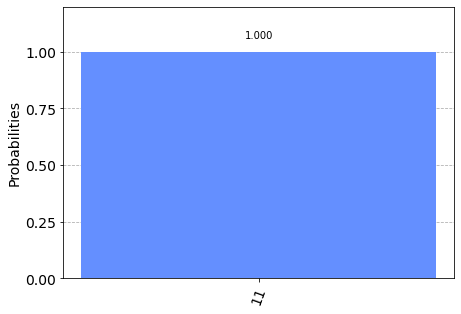

In [141]:

grover_circuit.measure_all()

aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(grover_circuit)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

In [144]:
# Experiment with Real Devices 
# Load IBM Q account and get the least busy backend device
IBMQ.save_account(MY_API_TOKEN,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider("ibm-q")
device = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("Running on current least busy device: ", device)

ibmqfactory.load_account:WARNING:2021-06-26 17:37:13,449: Credentials are already in use. The existing account in the session will be replaced.


Running on current least busy device:  ibmqx2


In [145]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


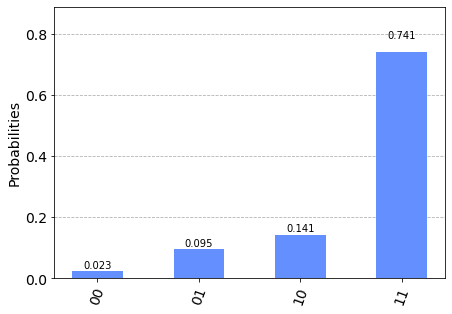

In [146]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

In [ ]:
# We confirm that in the majority of the cases the state  |11> is measured. The other results are due to errors in the quantum computation.

In [147]:
# 3 qubits
qc = QuantumCircuit(3)
qc.cz(0, 2)
qc.cz(1, 2)
oracle_ex3 = qc.to_gate()
oracle_ex3.name = "U$_\omega$"

In [148]:
# GENERAL DIFFUSER CIRCUIT
def diffuser(nqubits):
    qc = QuantumCircuit(nqubits)
    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    # We will return the diffuser as a gate
    U_s = qc.to_gate()
    U_s.name = "U$_s$"
    return U_s

In [149]:
n = 3
grover_circuit = QuantumCircuit(n)
# uniform supersposition
grover_circuit = initialize_s(grover_circuit, [0,1,2])
grover_circuit.append(oracle_ex3, [0,1,2])
grover_circuit.append(diffuser(n), [0,1,2])
grover_circuit.measure_all()
grover_circuit.draw()
#are 2 solutions and 8 possibilities, => 1. run of the ckt

┌───┐┌─────────────┐┌────────┐ ░ ┌─┐      
   q_0: ┤ H ├┤0            ├┤0       ├─░─┤M├──────
        ├───┤│             ││        │ ░ └╥┘┌─┐   
   q_1: ┤ H ├┤1 U$_\omega$ ├┤1 U$_s$ ├─░──╫─┤M├───
        ├───┤│             ││        │ ░  ║ └╥┘┌─┐
   q_2: ┤ H ├┤2            ├┤2       ├─░──╫──╫─┤M├
        └───┘└─────────────┘└────────┘ ░  ║  ║ └╥┘
meas: 3/══════════════════════════════════╩══╩══╩═
                                          0  1  2

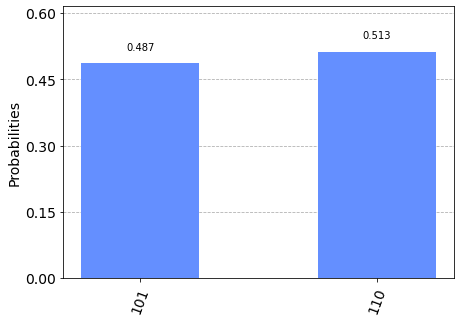

In [150]:
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)

In [151]:
#  algorithm discovers our marked states
# now, run on real device
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 3 and 
                                   not x.configuration().simulator and x.status().operational==True))
print("least busy backend: ", backend)

least busy backend:  ibmq_belem


In [152]:
# Run our circuit on the least busy backend. Monitor the execution of the job in the queue
from qiskit.tools.monitor import job_monitor
transpiled_grover_circuit = transpile(grover_circuit, device, optimization_level=3)
job = device.run(transpiled_grover_circuit)
job_monitor(job, interval=2)

Job Status: job has successfully run


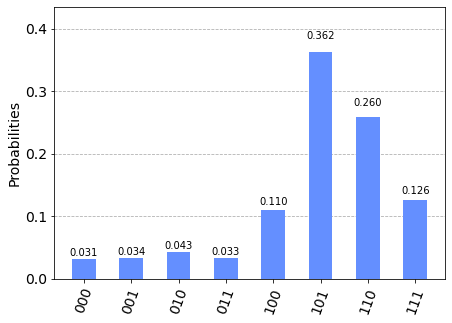

In [153]:
# Get the results from the computation
results = job.result()
answer = results.get_counts(grover_circuit)
plot_histogram(answer)

In [ ]:
#  higher chance of measuring   101 and 110; other results are due to errors in the quantum computation


In [154]:
# 4. Problems 
from qiskit_textbook.problems import grover_problem_oracle
## Example Usage
n = 4
oracle = grover_problem_oracle(n, variant=1)  # 0th variant of oracle, with n qubits
qc = QuantumCircuit(n)
qc.append(oracle, [0,1,2,3])
qc.draw()

┌────────────────────┐
q_0: ┤0                   ├
     │                    │
q_1: ┤1                   ├
     │  Oracle
n=4, var=1 │
q_2: ┤2                   ├
     │                    │
q_3: ┤3                   ├
     └────────────────────┘

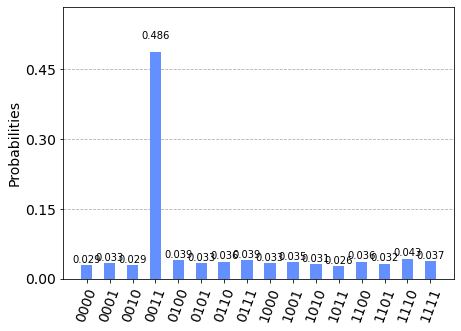

In [171]:
n=4
oracle = grover_problem_oracle(n, variant=2)  # 0th variant of oracle, with n qubits
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.append(oracle, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.measure_all()
grover_circuit.draw()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)
# 4 qubits => 2^4 means 16 possibilities, ~√16 or ~4 iterations for high probability
# 4 iterations ~100% certitude
# 4(.90) = 100(.90) => 3.6, so still 4 runs to get > 90% confidence
# multiplie iterations show the same result, correct answer stands out...

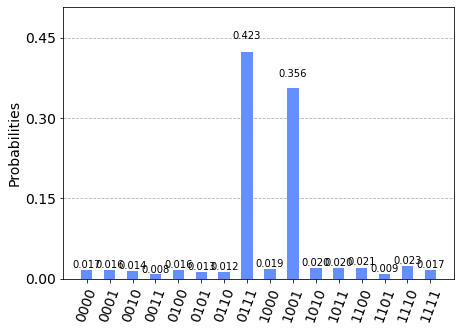

In [161]:
# With 2 solutions and 4 qubits, how many iterations do we need for a > 90% chance
# √16/2 = √8 ~100%, 2.82 ~100%, 2.82(.90) ~90, 2.5 ~ 90, so 3 runs gurantee > 90% certitude
n=4
oracle = grover_problem_oracle(n, variant=1)  # variant 1 has 2 sol
grover_circuit = QuantumCircuit(n)
grover_circuit = initialize_s(grover_circuit, [0,1,2,3])
grover_circuit.append(oracle, [0,1,2,3])
grover_circuit.append(diffuser(n), [0,1,2,3])
grover_circuit.measure_all()
grover_circuit.draw()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(grover_circuit, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)
# run once... multiple runs show same result 0011


iterations= 2


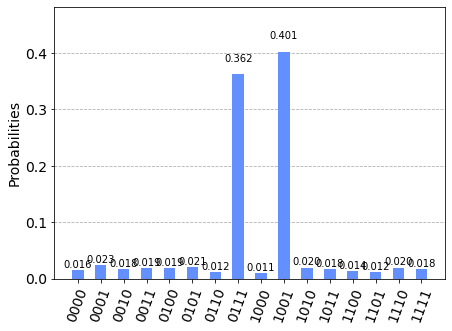

In [200]:
import math
def grover_solver(n, oracle, iterations):
    for i in range(iterations):
        grover_circuit = QuantumCircuit(n)
        qubits = list(range(n))
        grover_circuit = initialize_s(grover_circuit, qubits)
        grover_circuit.append(oracle, qubits)
        grover_circuit.append(diffuser(n), qubits)
    return grover_circuit
    
    
n=4    
iterations=math.floor(math.sqrt(n))
print("iterations=", iterations)
oracle = grover_problem_oracle(n, variant=1)  # variant 1 has 2 sol
gc = grover_solver(n, oracle, iterations)
gc.measure_all()
aer_sim = Aer.get_backend('aer_simulator')
transpiled_grover_circuit = transpile(gc, aer_sim)
qobj = assemble(transpiled_grover_circuit)
results = aer_sim.run(qobj).result()
counts = results.get_counts()
plot_histogram(counts)
# run once... multiple runs show same result 0011

In [201]:
# problem is a 2×2 binary sudoku
# rule1: No column may contain the same value twice
# rule2: No column may contain the same value twice
# v0 ≠ v1   # check along top row
# v2 ≠ v3   # check along bottom row
# v0 ≠ v2   # check down left column
# v1 ≠ v3   # check down right column
clause_list = [[0,1],
               [0,2],
               [1,3],
               [2,3]]
def XOR(qc, a, b, output):
    qc.cx(a, output)
    qc.cx(b, output)
    
# We will use separate registers to name the bits
in_qubits = QuantumRegister(2, name='input')
out_qubit = QuantumRegister(1, name='output')
qc = QuantumCircuit(in_qubits, out_qubit)
XOR(qc, in_qubits[0], in_qubits[1], out_qubit)
qc.draw()

#To check each clause, we repeat this circuit for each pairing in clause_list and store the output to a new bit:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')  # variable bits
clause_qubits = QuantumRegister(4, name='c')  # bits to store clause-checks

# Create quantum circuit
qc = QuantumCircuit(var_qubits, clause_qubits)

# Use XOR gate to check each clause
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

qc.draw()
#The final state of the bits c0, c1, c2, c3 will only all be 1 in the case that the assignments of v0, v1, v2, v3 are a solution to the sudoku

v_0: ──■─────────■───────────────────────────
       │         │                           
v_1: ──┼────■────┼─────────■─────────────────
       │    │    │         │                 
v_2: ──┼────┼────┼────■────┼─────────■───────
       │    │    │    │    │         │       
v_3: ──┼────┼────┼────┼────┼────■────┼────■──
     ┌─┴─┐┌─┴─┐  │    │    │    │    │    │  
c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼──
     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │  
c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼──
               └───┘└───┘┌─┴─┐┌─┴─┐  │    │  
c_2: ────────────────────┤ X ├┤ X ├──┼────┼──
                         └───┘└───┘┌─┴─┐┌─┴─┐
c_3: ──────────────────────────────┤ X ├┤ X ├
                                   └───┘└───┘

In [204]:
# Create separate registers to name bits
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit)

# Compute clauses
i = 0
for clause in clause_list:
    XOR(qc, clause[0], clause[1], clause_qubits[i])
    i += 1

# multi-controlled-Toffoli-gate:
# Flip 'output' bit if all clauses are satisfied
qc.mct(clause_qubits, output_qubit)

qc.draw()

v_0: ──■─────────■────────────────────────────────
         │         │                                
  v_1: ──┼────■────┼─────────■──────────────────────
         │    │    │         │                      
  v_2: ──┼────┼────┼────■────┼─────────■────────────
         │    │    │    │    │         │            
  v_3: ──┼────┼────┼────┼────┼────■────┼────■───────
       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       
  c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──
       └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  
  c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■──
                 └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │  
  c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──
                           └───┘└───┘┌─┴─┐┌─┴─┐  │  
  c_3: ──────────────────────────────┤ X ├┤ X ├──■──
                                     └───┘└───┘┌─┴─┐
out_0: ────────────────────────────────────────┤ X ├
                                               └───┘

In [207]:
# 5.2 Uncomputing, and Completing the Oracle 
# We can now turn this checking circuit into a Grover oracle using phase kickback. To recap, we have 3 registers:
# To adapt our checking circuit into a Grover oracle, we need to guarantee the bits in the second register (c) are always returned to the state
# initial state via uncomputation

var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

def sudoku_oracle(qc, clause_list, clause_qubits):
    # Compute clauses
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

    # Flip 'output' bit if all clauses are satisfied
    qc.mct(clause_qubits, output_qubit)

    # Uncompute clauses to reset clause-checking bits to 0
    i = 0
    for clause in clause_list:
        XOR(qc, clause[0], clause[1], clause_qubits[i])
        i += 1

sudoku_oracle(qc, clause_list, clause_qubits)
qc.draw()


»
    v_0: ──■─────────■──────────────────────────────────■─────────■────────────»
           │         │                                  │         │            »
    v_1: ──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──»
           │    │    │         │                        │    │    │         │  »
    v_2: ──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼──»
           │    │    │    │    │         │              │    │    │    │    │  »
    v_3: ──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼──»
         ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │  »
    c_0: ┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼──»
         └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │  »
    c_1: ──────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼──»
                   └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐»
    c_2: ────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├»
                             └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘»
    c_3: ──────────────────────────────┤ X ├┤ X ├──■───────────────────────────»
                                       └───┘└───┘┌─┴─┐                         »
  out_0: ────────────────────────────────────────┤ X ├─────────────────────────»
                                                 └───┘                         »
cbits: 4/══════════════════════════════════════════════════════════════════════»
                                                                               »
«                        
«    v_0: ───────────────
«                        
«    v_1: ───────────────
«                        
«    v_2: ───────■───────
«                │       
«    v_3: ──■────┼────■──
«           │    │    │  
«    c_0: ──┼────┼────┼──
«           │    │    │  
«    c_1: ──┼────┼────┼──
«         ┌─┴─┐  │    │  
«    c_2: ┤ X ├──┼────┼──
«         └───┘┌─┴─┐┌─┴─┐
«    c_3: ─────┤ X ├┤ X ├
«              └───┘└───┘
«  out_0: ───────────────
«                        
«cbits: 4/═══════════════
«

In [209]:
# All that's left to do now is to put this oracle into Grover's algorithm!
var_qubits = QuantumRegister(4, name='v')
clause_qubits = QuantumRegister(4, name='c')
output_qubit = QuantumRegister(1, name='out')
cbits = ClassicalRegister(4, name='cbits')
qc = QuantumCircuit(var_qubits, clause_qubits, output_qubit, cbits)

# Initialize 'out0' in state |->
qc.initialize([1, -1]/np.sqrt(2), output_qubit)

# Initialize qubits in state |s>
qc.h(var_qubits)
qc.barrier()  # for visual separation

## First Iteration
# Apply our oracle
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

## Second Iteration - UNCOMPUTATION
sudoku_oracle(qc, clause_list, clause_qubits)
qc.barrier()  # for visual separation
# Apply our diffuser
qc.append(diffuser(4), [0,1,2,3])

# Measure the variable qubits
qc.measure(var_qubits, cbits)

qc.draw(fold=-1)


┌───┐               ░                                                                                       ░ ┌────────┐                                                                                      ░ ┌────────┐┌─┐         
    v_0: ─────────────┤ H ├───────────────░───■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├──■─────────■──────────────────────────────────■─────────■────────────────────────────░─┤0       ├┤M├─────────
                      ├───┤               ░   │         │                                  │         │                            ░ │        │  │         │                                  │         │                            ░ │        │└╥┘┌─┐      
    v_1: ─────────────┤ H ├───────────────░───┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├──┼────■────┼─────────■────────────────────────┼────■────┼─────────■──────────────────░─┤1       ├─╫─┤M├──────
                      ├───┤               ░   │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │  │    │    │         │                        │    │    │         │                  ░ │  U$_s$ │ ║ └╥┘┌─┐   
    v_2: ─────────────┤ H ├───────────────░───┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├──┼────┼────┼────■────┼─────────■──────────────┼────┼────┼────■────┼─────────■────────░─┤2       ├─╫──╫─┤M├───
                      ├───┤               ░   │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │  │    │    │    │    │         │              │    │    │    │    │         │        ░ │        │ ║  ║ └╥┘┌─┐
    v_3: ─────────────┤ H ├───────────────░───┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├──┼────┼────┼────┼────┼────■────┼────■─────────┼────┼────┼────┼────┼────■────┼────■───░─┤3       ├─╫──╫──╫─┤M├
                      └───┘               ░ ┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘┌─┴─┐┌─┴─┐  │    │    │    │    │    │       ┌─┴─┐┌─┴─┐  │    │    │    │    │    │   ░ └────────┘ ║  ║  ║ └╥┘
    c_0: ─────────────────────────────────░─┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░───────────┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼────■──┤ X ├┤ X ├──┼────┼────┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░ └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │    │  └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │    │   ░            ║  ║  ║  ║ 
    c_1: ─────────────────────────────────░───────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░─────────────────────┤ X ├┤ X ├──┼────┼────┼────┼────■────────────┤ X ├┤ X ├──┼────┼────┼────┼───░────────────╫──╫──╫──╫─
                                          ░           └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │    │    │            └───┘└───┘┌─┴─┐┌─┴─┐  │    │   ░            ║  ║  ║  ║ 
    c_2: ─────────────────────────────────░─────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░───────────────────────────────┤ X ├┤ X ├──┼────┼────■──────────────────────┤ X ├┤ X ├──┼────┼───░────────────╫──╫──╫──╫─
                                          ░                     └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░                               └───┘└───┘┌─┴─┐┌─┴─┐  │                      └───┘└───┘┌─┴─┐┌─┴─┐ ░            ║  ║  ║  ║ 
    c_3: ─────────────────────────────────░───────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├─░─────────────────────────────────────────┤ X ├┤ X ├──■────────────────────────────────┤ X ├┤ X ├

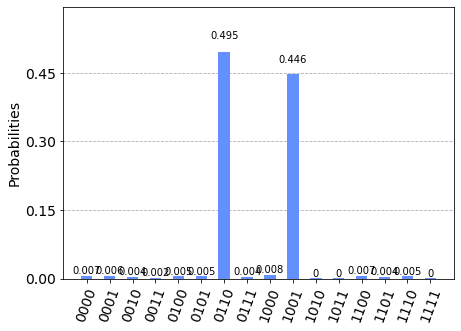

In [210]:
# Simulate and plot results
aer_simulator = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_simulator)
qobj = assemble(transpiled_qc)
result = aer_sim.run(qobj).result()
plot_histogram(result.get_counts())

In [ ]:
# 0110 and 1001 correspond to assignments:
#v0 = 0
#v1 = 1
#v2 = 1
#v3 = 0
#and

#v0 = 1
#v1 = 0
#v2 = 0
#v3 = 1

#which are the two solutions to our sudoku! The aim of this section 
#is to show how we can create Grover oracles from real problems. 
#While this specific problem is trivial, the process can be applied 
#(allowing large enough circuits) to any decision problem. To recap, the steps are:

#  Create a reversible classical circuit that identifies a correct solution
#. Use phase kickback and uncomputation to turn this circuit into an oracle
#. Use Grover's algorithm to solve this oracle



In [211]:
# QUANTUM COUNTER
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
import qiskit
from qiskit import QuantumCircuit, transpile, assemble, Aer

# import basic plot tools
from qiskit.visualization import plot_histogram

# In this guide will choose to ‘count’ on the first 4 qubits on our circuit 
# counting qubits t, so t=4
# The Controlled-Grover Iteration 
#  an example with an Oracle we know has 5 solutions, combined with a diffusion operator:
def example_grover_iteration():
    """Small circuit with 5/16 solutions"""
    # Do circuit
    qc = QuantumCircuit(4)
    # Oracle
    qc.h([2,3])
    qc.ccx(0,1,2)
    qc.h(2)
    qc.x(2)
    qc.ccx(0,2,3)
    qc.x(2)
    qc.h(3)
    qc.x([1,3])
    qc.h(2)
    qc.mct([0,1,3],2)
    qc.x([1,3])
    qc.h(2)
    # Diffuser
    qc.h(range(3))
    qc.x(range(3))
    qc.z(3)
    qc.mct([0,1,2],3)
    qc.x(range(3))
    qc.h(range(3))
    qc.z(3)
    return qc

# Create controlled-Grover
grit = example_grover_iteration().to_gate()
grit.label = "Grover"
cgrit = grit.control()

# We now need to create an inverse QFT. This code implements the QFT on n qubits:
def qft(n):
    """Creates an n-qubit QFT circuit"""
    circuit = QuantumCircuit(4)
    def swap_registers(circuit, n):
        for qubit in range(n//2):
            circuit.swap(qubit, n-qubit-1)
        return circuit
    def qft_rotations(circuit, n):
        """Performs qft on the first n qubits in circuit (without swaps)"""
        if n == 0:
            return circuit
        n -= 1
        circuit.h(n)
        for qubit in range(n):
            circuit.cp(np.pi/2**(n-qubit), qubit, n)
        qft_rotations(circuit, n)
    
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

qft_dagger = qft(4).to_gate().inverse()
qft_dagger.label = "QFT†"


In [212]:
# Create QuantumCircuit
t = 4   # no. of counting qubits
n = 4   # no. of searching qubits
qc = QuantumCircuit(n+t, t) # Circuit with n+t qubits and t classical bits

# Initialize all qubits to |+>
for qubit in range(t+n):
    qc.h(qubit)

# Begin controlled Grover iterations
iterations = 1
for qubit in range(t):
    for i in range(iterations):
        qc.append(cgrit, [qubit] + [*range(t, n+t)])
    iterations *= 2
    
# Do inverse QFT on counting qubits
qc.append(qft_dagger, range(t))

# Measure counting qubits
qc.measure(range(t), range(t))

# Display the circuit
qc.draw()

┌───┐                                                                  »
q_0: ┤ H ├─────■────────────────────────────────────────────────────────────»
     ├───┤     │                                                            »
q_1: ┤ H ├─────┼──────────■──────────■──────────────────────────────────────»
     ├───┤     │          │          │                                      »
q_2: ┤ H ├─────┼──────────┼──────────┼──────────■──────────■──────────■─────»
     ├───┤     │          │          │          │          │          │     »
q_3: ┤ H ├─────┼──────────┼──────────┼──────────┼──────────┼──────────┼─────»
     ├───┤┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
q_4: ┤ H ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_5: ┤ H ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├»
     ├───┤│  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover │»
q_6: ┤ H ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├»
     ├───┤│         ││         ││         ││         ││         ││         │»
q_7: ┤ H ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├»
     └───┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
c: 4/═══════════════════════════════════════════════════════════════════════»
                                                                            »
«                                                                       »
«q_0: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_1: ──────────────────────────────────────────────────────────────────»
«                                                                       »
«q_2: ─────■────────────────────────────────────────────────────────────»
«          │                                                            »
«q_3: ─────┼──────────■──────────■──────────■──────────■──────────■─────»
«     ┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐┌────┴────┐»
«q_4: ┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├┤0        ├»
«     │         ││         ││         ││         ││         ││         │»
«q_5: ┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├┤1        ├»
«     │  Grover ││  Grover ││  Grover ││  Grover ││  Grover ││  Grover │»
«q_6: ┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├┤2        ├»
«     │         ││         ││         ││         ││         ││         │»
«q_7: ┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├┤3        ├»
«     └─────────┘└─────────┘└─────────┘└─────────┘└─────────┘└─────────┘»
«c: 4/══════════════════════════════════════════════════════════════════»
«                                                                       »
«                                      ┌───────┐┌─┐         
«q_0: ─────────────────────────────────┤0      ├┤M├─────────
«                                      │       │└╥┘┌─┐      
«q_1: ─────────────────────────────────┤1      ├─╫─┤M├──────
«                                      │  QFT† │ ║ └╥┘┌─┐   
«q_2: ─────────────────────────────────┤2      ├─╫──╫─┤M├───
«                                      │       │ ║  ║ └╥┘┌─┐
«q_3: ─────■──────────■──────────■─────┤3      ├─╫──╫──╫─┤M├
«     ┌────┴────┐┌────┴────┐┌────┴────┐└───────┘ ║  ║  ║ └╥┘
«q_4: ┤0        ├┤0        ├┤0        ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_5: ┤1        ├┤1        ├┤1        ├──────────╫──╫──╫──╫─
«     │  Grover ││  Grover ││  Grover │          ║  ║  ║  ║ 
«q_6: ┤2        ├┤2        ├┤2        ├──────────╫──╫──╫──╫─
«     │         ││         ││         │          ║  ║  ║  ║ 
«q_7: ┤3        ├┤3        ├┤3        ├──────────╫──╫──╫──╫─
«     └─────────┘└─────────┘└─────────┘          ║  ║  ║  ║ 
«c: 4/═══════════════════════════════════════════╩══╩══╩══╩═
«                  

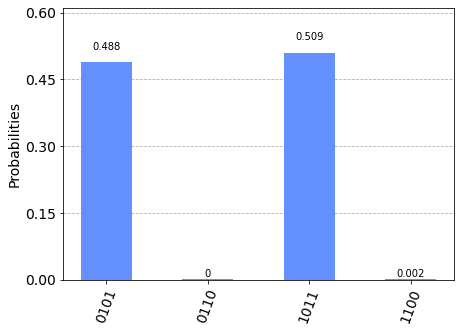

In [213]:
# Execute and see results
aer_sim = Aer.get_backend('aer_simulator')
transpiled_qc = transpile(qc, aer_sim)
qobj = assemble(transpiled_qc)
job = aer_sim.run(qobj)
hist = job.result().get_counts()
plot_histogram(hist)

In [214]:
measured_str = max(hist, key=hist.get)
measured_int = int(measured_str,2)
print("Register Output = %i" % measured_int)

Register Output = 11


In [215]:
# 4. Finding the Number of Solutions (M) 
theta = (measured_int/(2**t))*math.pi*2
print("Theta = %.5f" % theta)

Theta = 4.31969


In [216]:
# can get theta/2 from inner product of |s>. and |s'>

In [217]:
N = 2**n
M = N * (math.sin(theta/2)**2)
print("No. of Solutions = %.1f" % (N-M))

No. of Solutions = 4.9


In [218]:
#  we can see we have (approximately) the correct answer! We can approximately calculate the error in this answer using:
m = t - 1 # Upper bound: Will be less than this 
err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
print("Error < %.2f" % err)

Error < 2.48


In [219]:
# Explaining the error calculation is outside the scope of this article, but an explanation can be found in [1].
def calculate_M(measured_int, t, n):
    """For Processing Output of Quantum Counting"""
    # Calculate Theta
    theta = (measured_int/(2**t))*math.pi*2
    print("Theta = %.5f" % theta)
    # Calculate No. of Solutions
    N = 2**n
    M = N * (math.sin(theta/2)**2)
    print("No. of Solutions = %.1f" % (N-M))
    # Calculate Upper Error Bound
    m = t - 1 #Will be less than this (out of scope) 
    err = (math.sqrt(2*M*N) + N/(2**(m+1)))*(2**(-m))
    print("Error < %.2f" % err)

In [ ]:
# TBD


In [220]:
# QUANTUM TELEPORTATION
# Do the necessary imports
import numpy as np
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector, array_to_latex
from qiskit.extensions import Initialize
from qiskit_textbook.tools import random_state

In [221]:
## SETUP
# Protocol uses 3 qubits and 2 classical bits in 2 different registers
qr = QuantumRegister(3, name="q")    # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical bits
crx = ClassicalRegister(1, name="crx") # in 2 different registers
teleportation_circuit = QuantumCircuit(qr, crz, crx)

In [222]:
# TELAMON CREATES A BELL PAIR
def create_bell_pair(qc, a, b):
    """Creates a bell pair in qc using qubits a & b"""
    qc.h(a) # Put qubit a into state |+>
    qc.cx(a,b) # CNOT with a as control and b as target
## STEP 1
# In our case, Telamon entangles qubits q1 and q2
# Let's apply this to our circuit:
create_bell_pair(teleportation_circuit, 1, 2)
# And view the circuit so far:
teleportation_circuit.draw()    

q_0: ──────────
       ┌───┐     
  q_1: ┤ H ├──■──
       └───┘┌─┴─┐
  q_2: ─────┤ X ├
            └───┘
crz: 1/══════════
                 
crx: 1/══════════

In [223]:
def alice_gates(qc, psi, a):
    qc.cx(psi, a)
    qc.h(psi)

In [224]:
alice_gates(teleportation_circuit, 0, 1)
teleportation_circuit.draw()

┌───┐
  q_0: ────────────■──┤ H ├
       ┌───┐     ┌─┴─┐└───┘
  q_1: ┤ H ├──■──┤ X ├─────
       └───┘┌─┴─┐└───┘     
  q_2: ─────┤ X ├──────────
            └───┘          
crz: 1/════════════════════
                           
crx: 1/════════════════════

In [225]:
# Alice applies a measurement to both qubits that she owns,  q1 and psi: result into 2 classical bits
def measure_and_send(qc, a, b):
    """Measures qubits a & b and 'sends' the results to Bob"""
    qc.barrier()
    qc.measure(a,0)
    qc.measure(b,1)


In [226]:
# ## STEP 3
measure_and_send(teleportation_circuit, 0 ,1)
teleportation_circuit.draw()

┌───┐ ░ ┌─┐   
  q_0: ────────────■──┤ H ├─░─┤M├───
       ┌───┐     ┌─┴─┐└───┘ ░ └╥┘┌─┐
  q_1: ┤ H ├──■──┤ X ├──────░──╫─┤M├
       └───┘┌─┴─┐└───┘      ░  ║ └╥┘
  q_2: ─────┤ X ├───────────░──╫──╫─
            └───┘           ░  ║  ║ 
crz: 1/════════════════════════╩══╬═
                               0  ║ 
                                  ║ 
crx: 1/═══════════════════════════╩═
                                  0

In [229]:
# Bob, who already has the qubit q2 applies gates depending on the state of the classical bits:
# (Note that this transfer of information is purely classical.)
# This function takes a QuantumCircuit (qc), integer (qubit)
# and ClassicalRegisters (crz & crx) to decide which gates to apply
def bob_gates(qc, qubit, crz, crx):
    # Here we use c_if to control our gates with a classical
    # bit instead of a qubit
    qc.x(qubit).c_if(crx, 1) # Apply gates if the registers 
    qc.z(qubit).c_if(crz, 1) # are in the state '1'

## STEP 4
teleportation_circuit.barrier() # Use barrier to separate steps
bob_gates(teleportation_circuit, 2, crz, crx)
teleportation_circuit.draw()


┌───┐ ░ ┌─┐    ░                ░               
  q_0: ────────────■──┤ H ├─░─┤M├────░────────────────░───────────────
       ┌───┐     ┌─┴─┐└───┘ ░ └╥┘┌─┐ ░                ░               
  q_1: ┤ H ├──■──┤ X ├──────░──╫─┤M├─░────────────────░───────────────
       └───┘┌─┴─┐└───┘      ░  ║ └╥┘ ░  ┌───┐  ┌───┐  ░  ┌───┐  ┌───┐ 
  q_2: ─────┤ X ├───────────░──╫──╫──░──┤ X ├──┤ Z ├──░──┤ X ├──┤ Z ├─
            └───┘           ░  ║  ║  ░  └─╥─┘  └─╥─┘  ░  └─╥─┘  └─╥─┘ 
                               ║  ║       ║   ┌──╨──┐      ║   ┌──╨──┐
crz: 1/════════════════════════╩══╬═══════╬═══╡ = 1 ╞══════╬═══╡ = 1 ╞
                               0  ║    ┌──╨──┐└─────┘   ┌──╨──┐└─────┘
crx: 1/═══════════════════════════╩════╡ = 1 ╞══════════╡ = 1 ╞═══════
                                  0    └─────┘          └─────┘

In [230]:
# And voila! At the end of this protocol, Alice's qubit has now teleported to Bob.


<IPython.core.display.Latex object>

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


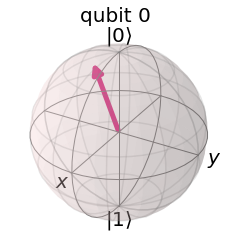

In [231]:
# 3.1 How Will We Test the Protocol on a Quantum Computer? 
# Create random 1-qubit state
psi = random_state(1)
# Display it nicely
display(array_to_latex(psi, prefix="|\\psi\\rangle ="))
# Show it on a Bloch sphere
plot_bloch_multivector(psi)

In [236]:
# Let's use our initialization instruction to create psi from |0>
init_gate = Initialize(psi)
init_gate.label = "init"
#If the quantum teleportation circuit works, then at the end of the circuit, q2 will be in the state psi was initialized.
#will be in this state. We will check this using the statevector simulator.

#We can use the statevector simulator to verify our qubit has been teleported.
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

# Display the circuit
qc.draw()




┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ 
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘ 
                                             ║  ║    ║   ┌──╨──┐
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞
                                             0  ║ ┌──╨──┐└─────┘
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════
                                                0 └─────┘

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/qiskit/visualization/bloch.py:69: MatplotlibDeprecationWarning: 
The M attribute was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use self.axes.M instead.
  x_s, y_s, _ = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)


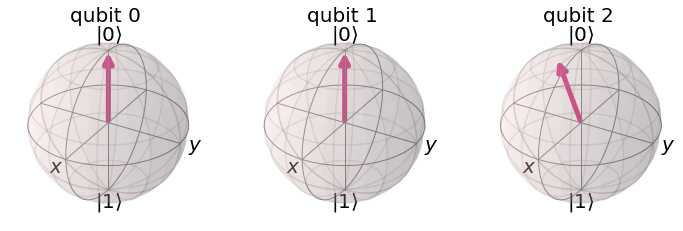

In [237]:
# q2 same as psi
# q0, q1 collapsed to |0> or |1>
# psi teleported from q0 to q2
sim = Aer.get_backend('aer_simulator')
qc.save_statevector()
out_vector = sim.run(qc).result().get_statevector()
plot_bloch_multivector(out_vector)

In [247]:
# Quantum teleportation is designed to send qubits between two parties.
# we can show gates perform the correct transformations on a single quantum chip
# On a real quantum computer, we test different to verify circuit workz# 
#  Initialize instruction first performs a reset, set out psi to |0>, applies gates to get our psi
#Since all quantum gates are reversible, we can find the inverse of these gates using:
inverse_init_gate = init_gate.gates_to_uncompute() # resets to |0>
#prove q0 teleported to q2, inv(q2), test equals |0> when measure
## SETUP
qr = QuantumRegister(3, name="q")   # Protocol uses 3 qubits
crz = ClassicalRegister(1, name="crz") # and 2 classical registers
crx = ClassicalRegister(1, name="crx")
qc = QuantumCircuit(qr, crz, crx)

## STEP 0
# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

## STEP 1
# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()

## STEP 2
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)

## STEP 3
# Alice then sends her classical bits to Bob
measure_and_send(qc, 0, 1)

## STEP 4
# Bob decodes qubits
bob_gates(qc, 2, crz, crx)

## STEP 5
# reverse the initialization process
qc.append(inverse_init_gate, [2])

# Display the circuit
qc.draw()



┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─»
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘ »
                                             ║  ║    ║   ┌──╨──┐»
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞»
                                             0  ║ ┌──╨──┐└─────┘»
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════»
                                                0 └─────┘       »
«                       
«  q_0: ────────────────
«                       
«  q_1: ────────────────
«       ┌──────────────┐
«  q_2: ┤ disentangler ├
«       └──────────────┘
«crz: 1/════════════════
«                       
«crx: 1/════════════════
«

In [248]:
# Need to add a new ClassicalRegister
# to see the result
# measure the third qubit and store the result in the third classical bit:
cr_result = ClassicalRegister(1)
qc.add_register(cr_result)
qc.measure(2,2)
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░ ┌─┐                 »
  q_0: ┤ init ├─░────────────░───■──┤ H ├─░─┤M├─────────────────»
       └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐              »
  q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░──╫─┤M├──────────────»
                ░ └───┘┌─┴─┐ ░ └───┘      ░  ║ └╥┘ ┌───┐  ┌───┐ »
  q_2: ─────────░──────┤ X ├─░────────────░──╫──╫──┤ X ├──┤ Z ├─»
                ░      └───┘ ░            ░  ║  ║  └─╥─┘  └─╥─┘ »
                                             ║  ║    ║   ┌──╨──┐»
crz: 1/══════════════════════════════════════╩══╬════╬═══╡ = 1 ╞»
                                             0  ║ ┌──╨──┐└─────┘»
crx: 1/═════════════════════════════════════════╩═╡ = 1 ╞═══════»
                                                0 └─────┘       »
 c7: 1/═════════════════════════════════════════════════════════»
                                                                »
«                          
«  q_0: ───────────────────
«                          
«  q_1: ───────────────────
«       ┌──────────────┐┌─┐
«  q_2: ┤ disentangler ├┤M├
«       └──────────────┘└╥┘
«crz: 1/═════════════════╬═
«                        ║ 
«crx: 1/═════════════════╬═
«                        ║ 
« c7: 1/═════════════════╩═
«                        0

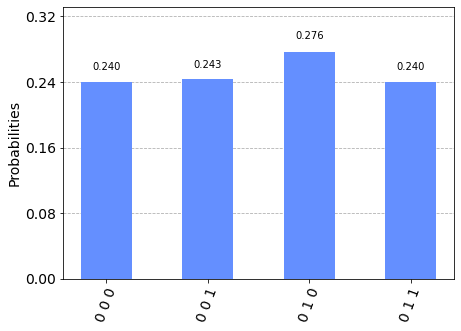

In [249]:
#and we run our experiment:
t_qc = transpile(qc, sim)
t_qc.save_statevector()
counts = sim.run(t_qc).result().get_counts()
plot_histogram(counts)

In [ ]:
# We can see we have a 100% chance of measuring q2 in |0>
# the leftmost bit in the string....
# expected result, and indicates the teleportation protocol has worked properly.




In [251]:
# The IBM quantum computers currently do not support instructions after measurements
# we cannot run the quantum teleportation in its current form on real hardware....
# does not limit our ability to perform any computations due to the deferred measurement principle discussed in chapter 4.4 of [1]. 
# principle states that any measurement can be postponed until the end of the circuit, i.e. we can move all the measurements to the end, and we should see the same results.

# Any benefits of measuring early are hardware related: 

# While moving the gates allows us to demonstrate the "teleportation" circuit on real hardware, 
# the benefit of the teleportation process (transferring quantum states via classical channels) is lost.

# Let us re-write the bob_gates function to new_bob_gates:

def new_bob_gates(qc, a, b, c):
    qc.cx(b, c)
    qc.cz(a, c)

qc = QuantumCircuit(3,1)

# First, let's initialize Alice's q0
qc.append(init_gate, [0])
qc.barrier()

# Now begins the teleportation protocol
create_bell_pair(qc, 1, 2)
qc.barrier()
# Send q1 to Alice and q2 to Bob
alice_gates(qc, 0, 1)
qc.barrier()
# Alice sends classical bits to Bob
new_bob_gates(qc, 0, 1, 2)

# We undo the initialization process
qc.append(inverse_init_gate, [2])

# See the results, we only care about the state of qubit 2
qc.measure(2,0)

# View the results:
qc.draw()

┌──────┐ ░            ░      ┌───┐ ░                            
q_0: ┤ init ├─░────────────░───■──┤ H ├─░───────■────────────────────
     └──────┘ ░ ┌───┐      ░ ┌─┴─┐└───┘ ░       │                    
q_1: ─────────░─┤ H ├──■───░─┤ X ├──────░───■───┼────────────────────
              ░ └───┘┌─┴─┐ ░ └───┘      ░ ┌─┴─┐ │ ┌──────────────┐┌─┐
q_2: ─────────░──────┤ X ├─░────────────░─┤ X ├─■─┤ disentangler ├┤M├
              ░      └───┘ ░            ░ └───┘   └──────────────┘└╥┘
c: 1/══════════════════════════════════════════════════════════════╩═
                                                                   0

In [253]:
# First, see what devices we are allowed to use by loading our saved accounts
IBMQ.save_account(MY_API_TOKEN,overwrite=True)
IBMQ.load_account()
provider = IBMQ.get_provider(hub='ibm-q')
# get the least-busy backend at IBM and run the quantum circuit there
from qiskit.providers.ibmq import least_busy
from qiskit.tools.monitor import job_monitor
backend = least_busy(provider.backends(filters=lambda b: b.configuration().n_qubits >= 3 and
                                   not b.configuration().simulator and b.status().operational==True))
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)
job_monitor(job)  # displays job status under cell

ibmqfactory.load_account:WARNING:2021-06-28 18:21:51,178: Credentials are already in use. The existing account in the session will be replaced.


Job Status: job has successfully run


{'0': 895, '1': 129}


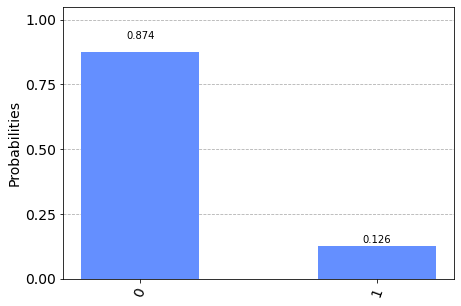

In [254]:
# Get the results and display them
exp_result = job.result()
exp_counts = exp_result.get_counts(qc)
print(exp_counts)
plot_histogram(exp_counts)

In [ ]:
#  there are a few results in which we measured |1>
# These arise due to errors in the gates and the qubits
# In contrast, our simulator in the earlier part of the notebook had zero errors in its gates, and allowed error-free teleportation.

In [255]:
print(f"The experimental error rate : {exp_counts['1']/sum(exp_counts.values()):.3f}%")


The experimental error rate : 0.126%


In [256]:
print(exp_counts)

{'0': 895, '1': 129}


In [257]:
exp_counts['1']

129

In [258]:
# SUPERDENSE CODING
# Importing everything
from qiskit import QuantumCircuit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit.visualization import plot_histogram

In [259]:
#Define a function that takes a QuantumCircuit (qc) 
# and two integers (qubit a  and qubit b)
def create_bell_pair(qc, a, b):
    qc.h(a) # Apply a h-gate to the first qubit
    qc.cx(a,b) # Apply a CNOT, using the first qubit as the control

In [262]:
# Next we need to encode our message. We saw that there were four possible messages we could send: 00, 10, 01 or 11.
# function that takes this message and applies the appropriate gates for us:
# Define a function that takes a QuantumCircuit (qc)
# a qubit index (qubit) and a message string (msg)
def encode_message(qc, qubit, msg):
    if msg == "00":
        pass    # To send 00 we do nothing
    elif msg == "10":
        qc.x(qubit) # To send 10 we apply an X-gate
    elif msg == "01":
        qc.z(qubit) # To send 01 we apply a Z-gate
    elif msg == "11":
        qc.z(qubit) # To send 11, we apply a Z-gate
        qc.x(qubit) # followed by an X-gate
    else:
        print("Invalid Message: Sending '00'")

In [263]:
def decode_message(qc, a, b):
    qc.cx(a,b)
    qc.h(a)

In [264]:
# Finally, we can put this together to complete our protocol.
# Create the quantum circuit with 2 qubits
qc = QuantumCircuit(2)


# First, Charlie creates the entangled pair between Alice and Bob
create_bell_pair(qc, 0, 1)
qc.barrier() # This adds a barrier to our circuit. A barrier 
             # separates the gates in our diagram and makes it 
             # clear which part of the circuit is which

# At this point, qubit 0 goes to Alice and qubit 1 goes to Bob

# Next, Alice encodes her message onto qubit 0. In this case,
# we want to send the message '10'. You can try changing this
# value and see how it affects the circuit
message = "10"
encode_message(qc, 0, message)
qc.barrier()
# Alice then sends her qubit to Bob.

# After recieving qubit 0, Bob applies the recovery protocol:
decode_message(qc, 0, 1)

# Finally, Bob measures his qubits to read Alice's message
qc.measure_all()

# Draw our output
qc.draw()



┌───┐      ░ ┌───┐ ░      ┌───┐ ░ ┌─┐   
   q_0: ┤ H ├──■───░─┤ X ├─░───■──┤ H ├─░─┤M├───
        └───┘┌─┴─┐ ░ └───┘ ░ ┌─┴─┐└───┘ ░ └╥┘┌─┐
   q_1: ─────┤ X ├─░───────░─┤ X ├──────░──╫─┤M├
             └───┘ ░       ░ └───┘      ░  ║ └╥┘
meas: 2/═══════════════════════════════════╩══╩═
                                           0  1

{'10': 1024}


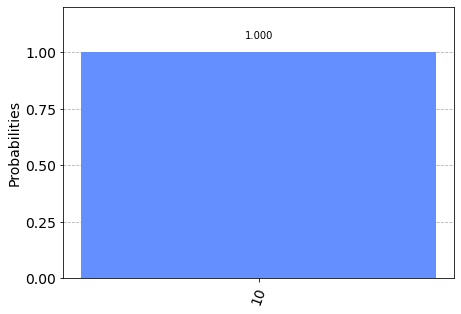

In [265]:
aer_sim = Aer.get_backend('aer_simulator')
qobj = assemble(qc)
result = aer_sim.run(qobj).result()
counts = result.get_counts(qc)
print(counts)
plot_histogram(counts)

In [277]:
# Our simulator simulates a perfect quantum computer. We can see that, without errors, we get a 100% chance of measuring the correct message.
# 4. Superdense Coding on a Real Quantum Computer
from qiskit import IBMQ
from qiskit.providers.ibmq import least_busy
shots = 1024

# Load local account information
IBMQ.save_account(MY_API_TOKEN,overwrite=True)
IBMQ.load_account()
# Get the least busy backend
provider = IBMQ.get_provider(hub='ibm-q')
backend = least_busy(provider.backends(filters=lambda x: x.configuration().n_qubits >= 2 
                                       and not x.configuration().simulator 
                                       and x.status().operational==True))
print("least busy backend: ", backend)
# Run our circuit
t_qc = transpile(qc, backend, optimization_level=3)
job = backend.run(t_qc)

ibmqfactory.load_account:WARNING:2021-06-29 17:30:35,734: Credentials are already in use. The existing account in the session will be replaced.


least busy backend:  ibmq_lima


In [278]:
# Monitoring our job
from qiskit.tools.monitor import job_monitor
job_monitor(job)

Job Status: job has successfully run


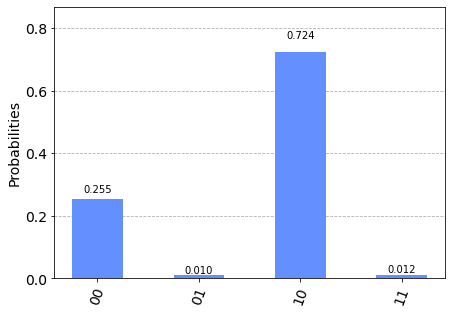

In [279]:
# Plotting our result
result = job.result()
plot_histogram(result.get_counts(qc))

In [ ]:
# As we see that there are a few results from the other three states when run in a real quantum computer. These are due to errors in the gates and qubit decoherence. 
# We will learn more about these errors in later sections.


In [280]:
correct_results = result.get_counts(qc)[message]
accuracy = (correct_results/shots)*100
print(f"Accuracy = {accuracy:.2f}%")

Accuracy = 72.36%


Imports Successful


┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

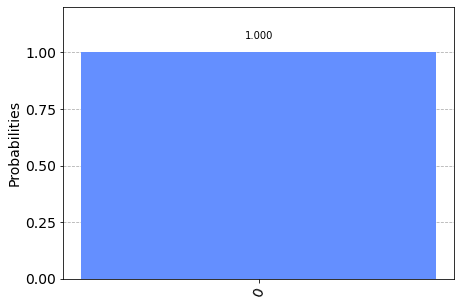

In [281]:
# Quantum Key Distribution
#2. Protocol Overview 
from qiskit import QuantumCircuit, Aer, transpile, assemble
from qiskit.visualization import plot_histogram, plot_bloch_multivector
from numpy.random import randint
import numpy as np
print("Imports Successful")
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
qc.barrier()
# Alice now sends the qubit to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

┌───┐┌─┐ ░ ┌───┐┌─┐
q_0: ┤ H ├┤M├─░─┤ H ├┤M├
     └───┘└╥┘ ░ └───┘└╥┘
c: 1/══════╩══════════╩═
           0          0

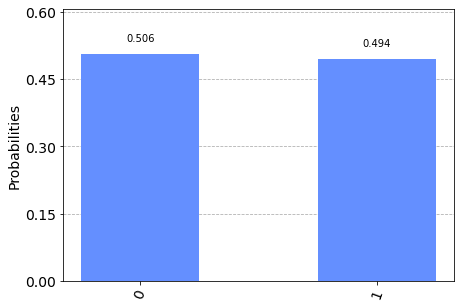

In [282]:
# But if Eve tries to measure this qubit in the  Z-basis 
qc = QuantumCircuit(1,1)
# Alice prepares qubit in state |+>
qc.h(0)
# Alice now sends the qubit to Bob
# but Eve intercepts and tries to read it
qc.measure(0, 0)
qc.barrier()
# Eve then passes this on to Bob
# who measures it in the X-basis
qc.h(0)
qc.measure(0,0)

# Draw and simulate circuit
display(qc.draw())
aer_sim = Aer.get_backend('aer_simulator')
job = aer_sim.run(assemble(qc))
plot_histogram(job.result().get_counts())

In [295]:
# We can see here that Bob now has a 50% chance of measuring 1, and if he does, he and Alice will know there is something wrong with their channel.
# The quantum key distribution protocol involves repeating this process enough times that an eavesdropper has a negligible chance of getting away with this interception. 

#STEP1: Alice chooses a string of random bits, e.g.:1000101011010100
# AND And a random choice of basis for each bit: ZZXZXXXZXZXXXXXX
# KEEPS BOTH PRIVATE

# step 2:Alice then encodes each bit onto a string of qubits using the basis she chose;
#This is the message she sends to Bob.

# step 3: Bob then measures each qubit at random, for example, he might use the bases: XZZZXZXZXZXZZZXZ
#And Bob keeps the measurement results private.

#STEP 4: Bob and Alice then publicly share which basis they used for each qubit.
#If Bob measured a qubit in the same basis Alice prepared it in, they use this to form part of their shared secret key, otherwise they discard the information for that bit.

# STEP 5:Finally, Bob and Alice share a random sample of their keys, and if the samples match, they can be sure (to a small margin of error) that their transmission is successful.

# 3. Qiskit Example: Without Interception 
#To generate pseudo-random keys, we will use the randint function from numpy. 
np.random.seed(seed=0)
# call the length of Alice's initial message n. In this example, 
# Alice will send a message 100 qubits long:
n = 100
np.random.seed(seed=0)
n = 100
## Step 1
# Alice generates bits (private to alice)
alice_bits = randint(2, size=n)
print(alice_bits)

[0 1 1 0 1 1 1 1 1 1 1 0 0 1 0 0 0 0 0 1 0 1 1 0 0 1 1 1 1 0 1 0 1 0 1 1 0
 1 1 0 0 1 0 1 1 1 1 1 0 1 0 1 1 1 1 0 1 0 0 1 1 0 1 0 1 0 0 0 0 0 1 1 0 0
 0 1 1 0 1 0 0 1 0 1 1 1 1 1 1 0 1 1 0 0 1 0 0 1 1 0]


In [296]:
#Alice chooses to encode each bit on qubit in the X or Z basis at random
#stores the choice for each qubit in alice_bases
## Step 2
# Create an array to tell us which qubits
# are encoded in which bases
alice_bases = randint(2, size=n)
print(alice_bases) # let 0 = Z, and 1 = X.; BASES ARE PRIVATE 

[1 0 0 1 0 0 0 1 1 0 1 0 0 0 0 0 1 0 1 0 1 1 1 1 1 0 1 1 1 1 0 1 1 0 0 1 0
 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 1 0 1 1 1 0 1 0 0 1 0 1 1 0 0 1 0 1 0 1 0
 1 0 1 0 0 0 1 0 1 0 1 0 0 0 0 0 1 0 0 1 0 0 0 1 0 0]


In [297]:
# creates a list of QuantumCircuits each representing a qubit in Alice's message
def encode_message(bits, bases):
    message = []
    for i in range(n):
        qc = QuantumCircuit(1,1)
        if bases[i] == 0: # Prepare qubit in Z-basis
            if bits[i] == 0:
                pass 
            else:
                qc.x(0)
        else: # Prepare qubit in X-basis
            if bits[i] == 0:
                qc.h(0)
            else:
                qc.x(0)
                qc.h(0)
        qc.barrier()
        message.append(qc)
    return message


In [298]:
message = encode_message(alice_bits, alice_bases)

In [299]:
print('bit = %i' % alice_bits[0])
print('basis = %i' % alice_bases[0])

bit = 0
basis = 1


In [300]:
# we can verify that Alice has prepared a qubit in the x-basis
message[0].draw()


┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
c: 1/════════

In [301]:
# As another example, we can see that the fourth bit a 1 in Z
print('bit = %i' % alice_bits[4])
print('basis = %i' % alice_bases[4])
message[4].draw()

bit = 1
basis = 0


┌───┐ ░ 
q_0: ┤ X ├─░─
     └───┘ ░ 
c: 1/════════

In [294]:
# This message of qubits is then sent to Bob over Eve's quantum channel:
# Bob then measures each qubit in the message using random basis for each
## Step 3
# Decide which basis to measure in:
bob_bases = randint(2, size=n)
print(bob_bases)

[1 0 1 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 0 0 0 1 1 1 0 0 1 1 1 1 0 0 0 1 1
 0 1 0 0 1 0 1 1 1 1 0 0 0 1 1 1 0 1 1 1 1 0 0 1 1 0 0 0 1 1 0 1 1 1 1 1 0
 0 0 1 0 1 0 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 0 0 0 1 1]


In [302]:
#  applies the corresponding measurement and simulates the result of measuring each qubit.
# We store the measurement results in bob_results.
def measure_message(message, bases):
    backend = Aer.get_backend('aer_simulator')
    measurements = []
    for q in range(n):
        if bases[q] == 0: # measuring in Z-basis
            message[q].measure(0,0)
        if bases[q] == 1: # measuring in X-basis
            message[q].h(0)
            message[q].measure(0,0)
        aer_sim = Aer.get_backend('aer_simulator')
        qobj = assemble(message[q], shots=1, memory=True)
        result = aer_sim.run(qobj).result()
        measured_bit = int(result.get_memory()[0])
        measurements.append(measured_bit)
    return measurements

In [303]:
bob_results = measure_message(message, bob_bases)


In [304]:
# We can see that the circuit in message[0] (representing the 0th qubit) has had an X-measurement
message[0].draw()


┌───┐ ░ ┌───┐┌─┐
q_0: ┤ H ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

In [306]:
# Since Bob has by chance chosen to measure in the same basis Alice encoded the qubit in, Bob is guaranteed to get the result 0.
# class on 6th qubit
message[6].draw()


┌───┐ ░ ┌───┐┌─┐
q_0: ┤ X ├─░─┤ H ├┤M├
     └───┘ ░ └───┘└╥┘
c: 1/══════════════╩═
                   0

In [307]:
print(bob_results)


[0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1]


In [309]:
#Bob keeps his results private.
# NOW REVEAL BASIS:
#If Bob happened to measure a bit in the same basis Alice prepared it in, this means the entry in bob_results will match the corresponding entry in alice_bits, and they can use that bit as part of their key.
def remove_garbage(a_bases, b_bases, bits):
    good_bits = []
    for q in range(n):
        if a_bases[q] == b_bases[q]:
            # If both used the same basis, add
            # this to the list of 'good' bits
            good_bits.append(bits[q])
    return good_bits
#Alice and Bob both discard the useless bits, and use the remaining bits to form their secret keys:
## Step 4
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
print(alice_key)
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
print(bob_key)

[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]
[0, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0]


In [310]:
assert(alice_key == bob_key)

In [312]:
#Finally, Bob and Alice compare a random selection of the bits in their keys to make sure the protocol has worked correctly:
def sample_bits(bits, selection):
    sample = []
    for i in selection:
        # use np.mod to make sure the
        # bit we sample is always in 
        # the list range
        i = np.mod(i, len(bits))
        # pop(i) removes the element of the
        # list at index 'i'
        sample.append(bits.pop(i))
    return sample
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)

bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]
alice_sample = [1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0]


In [ ]:
#Alice and Bob both broadcast these publicly, and remove them from their keys as they are no longer secret:

In [313]:
bob_sample == alice_sample
#if no interference

True

In [314]:
#They now share a secret key they can use to encrypt their messages!
print(bob_key)
print(alice_key)
print("key length = %i" % len(alice_key))

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0]
key length = 33


In [ ]:
# and remove sampled bits... :)

In [327]:
# 4. Qiskit Example: With Interception 
# Let’s now see how Alice and Bob can tell if Eve has been trying to listen in on their quantum message
# before Bob receives his qubits, Eve will try and extract some information from them.
# set a different seed so we get a specific set of reproducible 'random' results:
np.random.seed(seed=3)

In [328]:
## Step 1
alice_bits = randint(2, size=n)
print(alice_bits)

[0 0 1 1 0 0 0 1 1 1 0 1 1 1 0 1 1 0 0 0 0 1 1 0 0 0 1 0 0 0 0 1 0 1 1 0 1
 0 0 1 1 0 0 1 0 1 0 1 1 1 1 0 1 0 0 1 1 1 0 0 0 1 0 0 0 1 0 0 1 1 0 0 1 1
 1 0 1 1 1 1 1 1 0 1 0 0 1 1 0 1 0 0 0 0 0 1 1 0 1 1]


In [329]:
# Alice encodes these in -bases at random sends these to Bob through Eve's quantum channel:
## Step 2
alice_bases = randint(2, size=n)
message = encode_message(alice_bits, alice_bases)
print(alice_bases)

[1 0 0 1 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 1 1 0 0 1 1 0 0 1 1 1 1 0 0
 1 1 0 0 0 0 0 0 0 0 1 1 0 0 0 1 0 1 1 1 0 0 1 0 1 0 1 1 0 0 1 0 0 1 1 1 1
 1 0 0 0 0 0 1 1 1 0 0 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1]


In [330]:
# In this case, the first qubit in Alice's message is in the state |+>
message[0].draw()


┌───┐ ░ 
q_0: ┤ H ├─░─
     └───┘ ░ 
c: 1/════════

In [331]:
#Interception! EVE tries to measure the qubits in a random selection of bases, in the same way Bob will later.

In [332]:
## Interception!!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
print(intercepted_message)

[1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0]


In [333]:
#We can see the case of qubit 0 below; 
#Eve's random choice of basis is not the same as Alice's, 
#and this will change the qubit state from |+> to random Z-basis state each with 50% prob.
message[0].draw()



┌───┐ ░ ┌─┐
q_0: ┤ H ├─░─┤M├
     └───┘ ░ └╥┘
c: 1/═════════╩═
              0

In [334]:
#Eve then passes on the qubits to Bob, who measures them at random
#Without interception, Bob would be guaranteed to measure 0, but because Eve tried to read the message he now has a 50% chance of measuring 1 instead.
## Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
message[0].draw()

┌───┐ ░ ┌─┐┌───┐┌─┐
q_0: ┤ H ├─░─┤M├┤ H ├┤M├
     └───┘ ░ └╥┘└───┘└╥┘
c: 1/═════════╩═══════╩═
              0       0

In [335]:
#Bob and Alice reveal their basis choices, and discard the useless bits:
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)

In [336]:
# Bob and Alice compare the same random selection of their keys to see if the qubits were intercepted:
## Step 5
sample_size = 15
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
print("  bob_sample = " + str(bob_sample))
alice_sample = sample_bits(alice_key, bit_selection)
print("alice_sample = "+ str(alice_sample))

  bob_sample = [1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0]
alice_sample = [1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0]


In [337]:
bob_sample == alice_sample


False

In [ ]:
#Oh no! Bob's  and Alice's sample bits don't match
#For all Alice and Bob know, this could be due to noise in the channel, but either way they must throw away all their results and try again- Eve's interception attempt has failed.


In [ ]:
#5. Risk Analysis 
#For this type of interception, in which Eve measures all the qubits, there is a small chance that Bob and Alice's samples could match,
#Alice sends her vulnerable message through Eve's channel. Let's calculate that chance and see how risky quantum key distribution is.

#For Alice and Bob to use a qubit's result, they must both have chosen the same basis. If Eve chooses this basis too, she will successfully intercept this bit without introducing any error. There is a 50% chance of this happening.
#If Eve chooses the wrong basis, i.e. a different basis to Alice and Bob, there is still a 50% chance Bob will measure the value Alice was trying to send. In this case, the interception also goes undetected.
#But if Eve chooses the wrong basis, i.e. a different basis to Alice and Bob, there is a 50% chance Bob will not measure the value Alice was trying to send, and this will introduce an error into their keys.

In [338]:
n = 100
# Step 1
alice_bits = randint(2, size=n)
alice_bases = randint(2, size=n)
# Step 2
message = encode_message(alice_bits, alice_bases)
# Interception!
eve_bases = randint(2, size=n)
intercepted_message = measure_message(message, eve_bases)
# Step 3
bob_bases = randint(2, size=n)
bob_results = measure_message(message, bob_bases)
# Step 4
bob_key = remove_garbage(alice_bases, bob_bases, bob_results)
alice_key = remove_garbage(alice_bases, bob_bases, alice_bits)
# Step 5
sample_size = 15 # Change this to something lower and see if 
                 # Eve can intercept the message without Alice
                 # and Bob finding out
bit_selection = randint(n, size=sample_size)
bob_sample = sample_bits(bob_key, bit_selection)
alice_sample = sample_bits(alice_key, bit_selection)

if bob_sample != alice_sample:
    print("Eve's interference was detected.")
else:
    print("Eve went undetected!")

Eve's interference was detected.
